In [1]:
!wget https://github.com/callummcdougall/sae_visualizer/archive/refs/heads/main.zip
!unzip main.zip

from pathlib import Path
root = Path("sae_visualizer-main").rename("sae_visualizer")

%pip install transformer_lens
%pip install plotly
%pip install git+https://github.com/callummcdougall/eindex.git

import os, sys
os.remove("main.zip")
sys.path.append("sae_visualizer")


from IPython.display import display, HTML, clear_output
clear_output()

--2024-02-01 11:36:17--  https://github.com/callummcdougall/sae_visualizer/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/callummcdougall/sae_visualizer/zip/refs/heads/main [following]
--2024-02-01 11:36:17--  https://codeload.github.com/callummcdougall/sae_visualizer/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [ <=>                ] 442.93K  --.-KB/s    in 0.08s   

2024-02-01 11:36:18 (5.39 MB/s) - ‘main.zip’ saved [453561]

Archive:  main.zip
43d8d442851b41587710506b65c0258a60e3e231
   creating: sae_visualizer-main/
  inflating: sae_vis

OSError: [Errno 39] Directory not empty: 'sae_visualizer-main' -> 'sae_visualizer'

In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("sae_visualizer")

In [2]:
from transformer_lens import HookedTransformer, utils
import torch
from datasets import load_dataset
from typing import Dict
from tqdm.notebook import tqdm
import plotly.express as px
import json

from sae_visualizer.model_fns import AutoEncoderConfig, AutoEncoder
from sae_visualizer.data_fns import get_feature_data, FeatureData

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_grad_enabled(False)

def imshow(x, **kwargs):
    x_numpy = utils.to_numpy(x)
    px.imshow(x_numpy, **kwargs).show()

In [3]:
import pprint
import time
import gzip
import json
import numpy as np
from pathlib import Path
from typing import List
from dataclasses import dataclass
from transformer_lens import utils, HookedTransformer
from transformer_lens.hook_points import HookPoint
import torch
from torch import Tensor
from eindex import eindex
from IPython.display import display, HTML
from typing import Optional, List, Dict, Callable, Tuple, Union, Literal
from dataclasses import dataclass
import torch.nn.functional as F
import torch.nn as nn
import einops
from jaxtyping import Float, Int
from collections import defaultdict
from functools import partial
from rich import print as rprint
from rich.table import Table
import pickle
import os
from sae_visualizer.utils_fns import sample_unique_indices, TopK, k_largest_indices, random_range_indices, reshape, to_str_tokens

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

In [4]:
from SAETrainer import SAETrainer
import wandb

api = wandb.Api()
run = api.run("mega-alignment/sae/byniiz7n")
cfg = run.config
artifact_dir = api.artifact("georglange/serimats/model-byniiz7n:v1").download()

encoder = SAETrainer.load_from_checkpoint(os.path.join(artifact_dir, 'model.ckpt'), cfg, ).sae
encoder.cfg['concat_heads'] = True if encoder.cfg['head'] == 'cat' else False
#encoder.cfg['seq_len'] = 128
encoder.cfg['extraction_batch_size'] = 20
encoder.cfg['buffer_size'] = 1e6
cfg

wandb:   1 of 1 files downloaded.  


{'lr': 0.001,
 'head': 9,
 'layer': 9,
 'seq_len': 512,
 'd_hidden': 8192,
 'actv_name': 'blocks.9.attn.hook_z',
 'actv_size': 64,
 'ckpt_name': 'z-l9h9-l1_0.03-819.2M.ckpt',
 'batch_size': 2048,
 'wandb_name': 'z--l9h9-l1_0.03-819.2M',
 'buffer_size': 1000000.0,
 'train_steps': 400000,
 'dataset_name': 'Skylion007/openwebtext',
 'l1_coefficient': 0.03,
 'language_model': 'gpt2-small',
 'lr_warmup_steps': 3000,
 'resampling_steps': [50000, 100000, 150000, 200000],
 'n_resampler_samples': 819200,
 'extraction_batch_size': 20,
 'init_geometric_median': False,
 'standardize_activations': True,
 'n_resampling_watch_steps': 5000,
 'reconstruction_loss_batch_size': 16,
 'concat_heads': False}

In [4]:
import json

with open('/tmp/pycharm_project_451/models/connor-z-l9.cfg', 'rb') as f:
    ccfg = json.load(f)
ccfg['actv_name'] = ccfg['act_name']
ccfg['actv_size'] = ccfg['act_size']
ccfg['d_hidden'] = ccfg['dict_size']
ccfg['head'] = 'concat'
ccfg['dataset_name'] = 'Skylion007/openwebtext'
ccfg['extraction_batch_size'] = 100
ccfg['reconstruction_loss_batch_size'] = 16
ccfg['n_resampling_watch_steps'] = 1
ccfg['resampling_steps'] = []

In [5]:
from SparseAutoencoder import SparseAutoencoder

encoder = SparseAutoencoder.load('/tmp/pycharm_project_451/models/connor-z-l9.pt', ccfg)
encoder

SparseAutoencoder()

In [5]:
def sanity_check(ckpt_path, cfg, encoder):
 
    import text_dataset
    from text_dataset import TextDataset
    from torch.utils.data import DataLoader
    from activation_buffer import Buffer
    from metrics.reconstruction_loss import ReconstructionLoss
    import pytorch_lightning as pl
    
    dataset = load_dataset(cfg['dataset_name'], split='train')
    if 'TinyStories' in str(dataset) or 'pile' in str(dataset):
        dataset = dataset['train']
    dataset = dataset.shuffle()
    
    llm = HookedTransformer.from_pretrained(
        model_name='gpt2-small',
        # refactor_factored_attn_matrices=True,
        device='cpu'  # will be moved to GPU later by lightning
    )
    llm.requires_grad_(False)
    
    token_dataset = TextDataset(dataset, llm.to_tokens, encoder.cfg['extraction_batch_size'], drop_last_batch=False,
                                seq_len=encoder.cfg['seq_len'])
    
    text_dataset_loader = iter(DataLoader(token_dataset, batch_size=None, shuffle=False, num_workers=5,
                                          prefetch_factor=5, worker_init_fn=text_dataset.worker_init_fn))
    
    buffer_size = cfg['buffer_size']
    cfg['buffer_size'] = 1e5
    buffer = Buffer(
        llm.cuda(),
        text_dataset_loader,
        **cfg
    )
    cfg['buffer_size'] = buffer_size
    loader = torch.utils.data.DataLoader(buffer, batch_size=None, shuffle=False, num_workers=0)
    
    reconstruction_loss_metric_zero = ReconstructionLoss(llm, encoder,
                                                TextDataset(dataset, llm.to_tokens,
                                                            cfg['reconstruction_loss_batch_size'],
                                                            drop_last_batch=False,
                                                            seq_len=cfg['seq_len'])
                                                , cfg['actv_name'],
                                                cfg['head'], ablation_type='zero')
    reconstruction_loss_metric_mean = ReconstructionLoss(llm, encoder,
                                                TextDataset(dataset, llm.to_tokens,
                                                            cfg['reconstruction_loss_batch_size'],
                                                            drop_last_batch=False,
                                                            seq_len=cfg['seq_len'])
                                                , cfg['actv_name'],
                                                cfg['head'], ablation_type='mean')
    
    encoder_trainer = SAETrainer.load_from_checkpoint(ckpt_path, cfg, reconstruction_loss_metric_mean=reconstruction_loss_metric_mean,
                                                     reconstruction_loss_metric_zero=reconstruction_loss_metric_zero)
    encoder_trainer.sae = encoder
    trainer = pl.Trainer(devices=[0], max_steps=cfg['train_steps'], #logger=wandb_logger,
                         val_check_interval=2000, limit_val_batches=5, limit_test_batches=5,
                        #callbacks=[checkpoint_callback]
                         )
    from IPython.display import display, HTML, clear_output
    clear_output()
    trainer.test(encoder_trainer, loader)

In [6]:
sanity_check(os.path.join(artifact_dir, 'model.ckpt'), cfg, encoder)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/var/local/glang/anaconda3/envs/serimats/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_l0_loss          │      3.8172850608825684      │
│            val_l1            │    0.0023221310693770647     │
│           val_loss           │     0.01358823012560606      │
│           val_mse            │     0.011266099289059639     │
│ val_reconstruction_loss_mean │      0.6151914596557617      │
│ val_reconstruction_loss_zero │      0.6107689142227173      │
└──────────────────────────────┴──────────────────────────────┘

In [7]:
def get_batch_tokens(dataset_iter, batch_size, model, cfg):
    tokens = []
    total_tokens = 0
    while total_tokens < batch_size*cfg["seq_len"]:
        try:
            # Retrieve next item from iterator
            row = next(dataset_iter)["text"]
        except StopIteration:
            # Break the loop if dataset ends
            break

        # Tokenize the text with a check for max_length
        cur_toks = model.to_tokens(row)
        tokens.append(cur_toks)

        total_tokens += cur_toks.numel()

    # Check if any tokens were collected
    if not tokens:
        return None

    # Depending on your model's tokenization, you might need to pad the tokens here

    # Flatten the list of tokens
    flat_tokens = torch.cat(tokens, dim=-1).flatten()
    flat_tokens = flat_tokens[:batch_size * cfg["seq_len"]]
    reshaped_tokens = einops.rearrange(
        flat_tokens,
        "(batch seq_len) -> batch seq_len",
        batch=batch_size,
    )
    reshaped_tokens[:, 0] = model.tokenizer.bos_token_id
    return reshaped_tokens

def get_per_src_pos_dfa_all_heads(tokens, feature_id, encoder, model):
    _, cache = model.run_with_cache(tokens)
    layer = encoder.cfg["layer"]
    v = cache["v", layer] # [batch, src_pos, n_heads, d_head]
    if type(encoder.cfg['head']) == int:
        v_cat = v[:, :, encoder.cfg['head'], :]
    else:
        v_cat = einops.rearrange(v, "batch src_pos n_heads d_head -> batch src_pos (n_heads d_head)") # [batch, src_pos, n_heads*d_head]

    attn_weights = cache['pattern', layer]  # [batch, n_heads, dest_pos, src_pos]
    if type(encoder.cfg['head']) == int:
        attn_weights = attn_weights[:, encoder.cfg['head'], :, :].view(attn_weights.shape[0], 1, attn_weights.shape[2], attn_weights.shape[3])
    attn_weights_bcast = einops.repeat(attn_weights, "batch n_heads dest_pos src_pos -> batch dest_pos src_pos (n_heads d_head)", d_head=model.cfg.d_head)  # [batch, dest_pos, src_pos, n_heads*d_head]

    # Element-wise multiplication, removing the loop
    decomposed_z_cat = attn_weights_bcast * v_cat.unsqueeze(1)  # [batch, dest_pos, src_pos n_heads*d_head]

    per_src_pos_dfa = einops.einsum(
        decomposed_z_cat, encoder.W_enc[:, feature_id],
        "batch dest_pos src_pos d_model, d_model -> batch dest_pos src_pos",
    )
    return per_src_pos_dfa

@dataclass
class MinimalSequenceData:
    '''
    Class to store data for a given sequence, which will be turned into a JavaScript visulisation.
    Basically just wraps token_ids and the corresponding feature acts for some (prompt, feature_id) pair

    Before hover:
        str_tokens: list of string tokens in the sequence
        feat_acts: sizes of activations on this sequence

    '''
    token_ids: List[str]
    feat_acts: List[float]

    def __len__(self):
        return len(self.token_ids)

    def __str__(self):
        return f"MinimalSequenceData({''.join(self.token_ids)})"

    def _filter(self, float_list: List[List[float]], int_list: List[List[str]]):
        float_list = [[f for f in floats if f != 0] for floats in float_list]
        int_list = [[i for i, f in zip(ints, floats)] for ints, floats in zip(int_list, float_list)]
        return float_list, int_list


class MinimalSequenceDataBatch:
    '''
    Class to store a list of MinimalSequenceData objects at once, by passing in tensors or objects
    with an extra dimension at the start.

    Note, I'll be creating these objects by passing in objects which are either 2D (k seq_len)
    or 3D (k seq_len top5), but which are all lists (of strings/ints/floats).

    '''
    def __init__(self, **kwargs):
        self.seqs = [
            MinimalSequenceData(
                token_ids = kwargs["token_ids"][k],
                feat_acts = kwargs["feat_acts"][k],
            )
            for k in range(len(kwargs["token_ids"]))
        ]

    def __getitem__(self, idx: int) -> MinimalSequenceData:
        return self.seqs[idx]

    def __len__(self) -> int:
        return len(self.seqs)

    def __str__(self) -> str:
        return "\n".join([str(seq) for seq in self.seqs])


@torch.inference_mode()
def get_max_act_indices(
    encoder: AutoEncoder,
    model: HookedTransformer,
    tokens: Int[Tensor, "batch seq"],
    feature_idx: Union[int, List[int]],
    max_batch_size: Optional[int] = None,
    first_group_size: int = 20,
    verbose: bool = False,
):
    '''
    Gets (batch, pos) indices of the top activations for a given feature (or list of features)

    Args:
        feature_idx: int
            The identity of the feature we're looking at (i.e. we slice the weights of the encoder). A list of
            features is accepted (the result will be a list of FeatureData objects).
        max_batch_size: Optional[int]
            Optionally used to chunk the tokens, if it's a large batch

        buffer: Tuple[int, int]
            The number of tokens on either side of the feature, for the right-hand visualisation.

    Returns list of dictionaries that contain SequenceBatchData for each feature (see that class's docstring for more info).
    '''
    model.reset_hooks(including_permanent=True)

    # Make feature_idx a list, for convenience
    if isinstance(feature_idx, int): feature_idx = [feature_idx]
    n_feats = len(feature_idx)

    # Chunk the tokens, for less memory usage
    all_tokens = (tokens,) if max_batch_size is None else tokens.split(max_batch_size)
    all_tokens = [tok.to(device) for tok in all_tokens]

    # Create lists to store data, which we'll eventually concatenate
    all_feat_acts = []

    # Get encoder & decoder directions
    feature_act_dir = encoder.W_enc[:, feature_idx] # (d_mlp, feats)
    feature_bias = encoder.b_enc[feature_idx] # (feats,)
    #assert feature_act_dir.T.shape == feature_out_dir.shape #== (len(feature_idx), encoder.cfg.d_mlp)

    # ! Define hook function to perform feature ablation
    def hook_fn_act_post(act: Float[Tensor, "batch seq act_size"], hook: HookPoint):
        '''
        Encoder has learned x^j \approx b + \sum_i f_i(x^j)d_i where:
            - f_i are the feature activations
            - d_i are the feature output directions

        This hook function stores all the information we'll need later on. It doesn't actually perform feature ablation, because
        if we did this, then we'd have to run a different fwd pass for every feature, which is super wasteful! But later, we'll
        calculate the effect of feature ablation,  i.e. x^j <- x^j - f_i(x^j)d_i for i = feature_idx, only on the tokens we care
        about (the ones which will appear in the visualisation).
        '''
        if encoder.cfg["concat_heads"]:
            act = einops.rearrange(
                act, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
            )
        elif type(encoder.cfg['head']) == int:
            act = act[:, :, encoder.cfg['head'], :]
        feat_acts = encoder.encoder(act)[:, :, feature_idx] # [batch seq features]
        #x_cent = act - encoder.b_dec
        #feat_acts_pre = einops.einsum(x_cent, feature_act_dir, "batch seq act_size, act_size feats -> batch seq feats")
        #feat_acts = F.relu(feat_acts_pre + feature_bias)
        all_feat_acts.append(feat_acts)

    for _tokens in all_tokens:
        model.run_with_hooks(_tokens, return_type=None, fwd_hooks=[
            (encoder.cfg["actv_name"], hook_fn_act_post),
        ])

    # Stack the results, and check shapes
    feat_acts = torch.concatenate(all_feat_acts) # [batch seq feats]
    assert feat_acts[:, :-1].shape == tokens[:, :-1].shape + (len(feature_idx),)

    iterator = range(n_feats) if not(verbose) else tqdm.tqdm(range(n_feats), desc="Getting sequence data", leave=False)

    indices_list = []
    for feat in iterator:

        _feat_acts = feat_acts[..., feat] # [batch seq]

        indices = k_largest_indices(_feat_acts, k=first_group_size, largest=True)
        indices_list.append(indices)

    return indices_list

@torch.inference_mode()
def get_seq_data(
    encoder: AutoEncoder,
    model: HookedTransformer,
    tokens: Int[Tensor, "batch seq"],
    feature_idx: Union[int, List[int]],
    max_batch_size: Optional[int] = None,

    buffer: Tuple[int, int] = (5, 5),
    n_groups: int = 10,
    first_group_size: int = 20,
    other_groups_size: int = 5,
    verbose: bool = False,

):
    '''
    Gets data that will be used to create the sequences in the HTML visualisation.

    Args:
        feature_idx: int
            The identity of the feature we're looking at (i.e. we slice the weights of the encoder). A list of
            features is accepted (the result will be a list of FeatureData objects).
        max_batch_size: Optional[int]
            Optionally used to chunk the tokens, if it's a large batch

        buffer: Tuple[int, int]
            The number of tokens on either side of the feature, for the right-hand visualisation.

    Returns list of dictionaries that contain SequenceBatchData for each feature (see that class's docstring for more info).
    '''
    model.reset_hooks(including_permanent=True)

    # Make feature_idx a list, for convenience
    if isinstance(feature_idx, int): feature_idx = [feature_idx]
    n_feats = len(feature_idx)

    # Chunk the tokens, for less memory usage
    all_tokens = (tokens,) if max_batch_size is None else tokens.split(max_batch_size)
    all_tokens = [tok.to(device) for tok in all_tokens]

    # Create lists to store data, which we'll eventually concatenate
    all_feat_acts = []

    # Get encoder & decoder directions
    feature_act_dir = encoder.W_enc[:, feature_idx] # (d_mlp, feats)
    feature_bias = encoder.b_enc[feature_idx] # (feats,)
    #assert feature_act_dir.T.shape == feature_out_dir.shape #== (len(feature_idx), encoder.cfg.d_mlp)

    # ! Define hook function to perform feature ablation
    def hook_fn_act_post(act: Float[Tensor, "batch seq act_size"], hook: HookPoint):
        '''
        Encoder has learned x^j \approx b + \sum_i f_i(x^j)d_i where:
            - f_i are the feature activations
            - d_i are the feature output directions

        This hook function stores all the information we'll need later on. It doesn't actually perform feature ablation, because
        if we did this, then we'd have to run a different fwd pass for every feature, which is super wasteful! But later, we'll
        calculate the effect of feature ablation,  i.e. x^j <- x^j - f_i(x^j)d_i for i = feature_idx, only on the tokens we care
        about (the ones which will appear in the visualisation).
        '''
        if encoder.cfg["concat_heads"]:
            act = einops.rearrange(
                act, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
            )
        elif type(encoder.cfg['head']) == int:
            act = act[:, :, encoder.cfg['head'], :]
        feat_acts = encoder.encoder(act)[:, :, feature_idx] # [batch seq features]
        #x_cent = act - encoder.b_dec
        #feat_acts_pre = einops.einsum(x_cent, feature_act_dir, "batch seq act_size, act_size feats -> batch seq feats")
        #feat_acts = F.relu(feat_acts_pre + feature_bias)
        all_feat_acts.append(feat_acts)

    # ! Run the forward passes (triggering the hooks), concat all results

    # Run the model without hook (to store all the information we need, not to actually return anything)
    for _tokens in all_tokens:
        model.run_with_hooks(_tokens, return_type=None, fwd_hooks=[
            (encoder.cfg["actv_name"], hook_fn_act_post),
        ])

    # Stack the results, and check shapes
    feat_acts = torch.concatenate(all_feat_acts) # [batch seq feats]
    assert feat_acts[:, :-1].shape == tokens[:, :-1].shape + (len(feature_idx),)

    # ! Calculate all data for the right-hand visualisations, i.e. the sequences
    # TODO - parallelize this (it could probably be sped up by batching indices & doing all sequences at once, although those would be large tensors)
    # We do this in 2 steps:
    #   (1) get the indices per group, from the feature activations, for each of the 12 groups (top, bottom, 10 quantiles)
    #   (2) get a batch of SequenceData objects per group. This usually involves using eindex (i.e. indexing into the `tensors`
    #       tensor with the group indices), and it also requires us to calculate the effect of ablations (using feature activations
    #       and the clean residual stream values).

    sequence_data_list = []

    iterator = range(n_feats) if not(verbose) else tqdm.tqdm(range(n_feats), desc="Getting sequence data", leave=False)

    for feat in iterator:

        _feat_acts = feat_acts[..., feat] # [batch seq]

        k_largest_thing = k_largest_indices(_feat_acts, k=first_group_size, largest=True)

        # (1)
        indices_dict = {
            f"TOP ACTIVATIONS<br>MAX = {_feat_acts.max():.3f}": k_largest_indices(_feat_acts, k=first_group_size, largest=True),
            f"BOTTOM ACTIVATIONS<br>MIN = {_feat_acts.min():.3f}": k_largest_indices(_feat_acts, k=first_group_size, largest=False),
        }

        quantiles = torch.linspace(0, _feat_acts.max(), n_groups+1)
        for i in range(n_groups-1, -1, -1):
            lower, upper = quantiles[i:i+2]
            pct = ((_feat_acts >= lower) & (_feat_acts <= upper)).float().mean()
            indices = random_range_indices(_feat_acts, (lower, upper), k=other_groups_size)
            indices_dict[f"INTERVAL {lower:.3f} - {upper:.3f}<br>CONTAINS {pct:.3%}"] = indices

        # Concat all the indices together (in the next steps we do all groups at once)
        indices_full = torch.concat(list(indices_dict.values()))

        # (2)
        # ! We further split (2) up into 3 sections:
        #   (A) calculate the indices we'll use for this group (we need to get a buffer on either side of the target token for each seq),
        #       i.e. indices[..., 0] = shape (g, buf) contains the batch indices of the sequences, and indices[..., 1] = contains seq indices
        #   (B) index into all our tensors to get the relevant data (this includes calculating the effect of ablation)
        #   (C) construct the SequenceData objects, in the form of a SequenceDataBatch object

        # (A)
        # For each token index [batch, seq], we actually want [[batch, seq-buffer[0]], ..., [batch, seq], ..., [batch, seq+buffer[1]]]
        # We get one extra dimension at the start, because we need to see the effect on loss of the first token
        buffer_tensor = torch.arange(-buffer[0] - 1, buffer[1] + 1, device=indices_full.device)
        indices_full = einops.repeat(indices_full, "g two -> g buf two", buf=buffer[0] + buffer[1] + 2)
        indices_full = torch.stack([indices_full[..., 0], indices_full[..., 1] + buffer_tensor], dim=-1).cpu()

        # (B)
        # Template for indexing is new_tensor[k, seq] = tensor[indices_full[k, seq, 1], indices_full[k, seq, 2]], sometimes there's an extra dim at the end
        tokens_group = eindex(tokens, indices_full[:, 1:], "[g buf 0] [g buf 1]")
        feat_acts_group = eindex(_feat_acts, indices_full, "[g buf 0] [g buf 1]")

        # (C)
        # Now that we've indexed everything, construct the batch of SequenceData objects
        sequence_data = {}
        g_total = 0
        for group_name, indices in indices_dict.items():
            lower, upper = g_total, g_total + len(indices)
            sequence_data[group_name] = MinimalSequenceDataBatch(
                token_ids=tokens_group[lower: upper].tolist(),
                feat_acts=feat_acts_group[lower: upper, 1:].tolist(),
            )
            g_total += len(indices)

        # Add this feature's sequence data to the list
        sequence_data_list.append(sequence_data)

    return sequence_data_list


HTML_DIR = Path("sae_visualizer/html")
HTML_HOVERTEXT_SCRIPT = (HTML_DIR / "hovertext_script.html").read_text()
#HTML_TOKEN = (HTML_DIR / "token_template.html").read_text()
HTML_TOKEN = """<span class="hover-text">
    <span class="token" style="background-color: bg_color; border-bottom: 4px solid underline_color; font-weight: font_weight">this_token</span>
    <div class="tooltip">
        <div class="table-container">
            <table>
                <tr><td class="right-aligned">Token</td><td class="left-aligned"><code>this_token</code></td></tr>
                <tr><td class="right-aligned">Feature activation</td><td class="left-aligned">feat_activation</td></tr>
            </table>
            <!-- No effect! -->
          </div>
    </div>
</span>"""
CSS_DIR = Path("sae_visualizer/css")

CSS = "\n".join([
    (CSS_DIR / "general.css").read_text(),
    (CSS_DIR / "sequences.css").read_text(),
    (CSS_DIR / "tables.css").read_text(),
])



@dataclass
class LogitData:
  top_negative_logits: List[Tuple[str, float]]
  top_positive_logits: List[Tuple[str, float]]

@dataclass
class DecoderWeightsDistribution:
  n_heads: int
  allocation_by_head: List[float]

from matplotlib import colors
import numpy as np
from typing import List, Optional, Tuple
from pathlib import Path
import re

BG_COLOR_MAP = colors.LinearSegmentedColormap.from_list("bg_color_map", ["white", "darkorange"])

BLUE_BG_COLOR_MAP = colors.LinearSegmentedColormap.from_list("bg_color_map", ["white", "#6495ED"])


def generate_minimal_tok_html(
    vocab_dict: dict,
    this_token: str,
    bg_color: str,
    is_bold: bool = False,
    feat_act: float = 0.0,
):
    '''
    Creates a single sequence visualisation, by reading from the `token_template.html` file.

    Currently, a bunch of things are randomly chosen rather than actually calculated (we're going for
    proof of concept here).
    '''
    html_output = (
        HTML_TOKEN
        .replace("this_token", to_str_tokens(vocab_dict, this_token))
        .replace("feat_activation", f"{feat_act:+.3f}")
        .replace("font_weight", "bold" if is_bold else "normal")
        .replace("bg_color", bg_color)
    )
    return html_output

def generate_minimial_seq_html(
    vocab_dict: dict,
    token_ids: List[str],
    feat_acts: List[float],
    bold_idx: Optional[int] = None,
    color="orange"
):
    assert len(token_ids) == len(feat_acts), f"All input lists must be of the same length. token_ids: {len(token_ids)}, feat_acts: {len(feat_acts)}"

    # ! Clip values in [0, 1] range (temporary)
    #bg_values = np.clip(feat_acts, 0, 1)
    bg_values = feat_acts


    # Define the HTML object, which we'll iteratively add to
    html_output = '<div class="seq">'  # + repeat_obj

    for i in range(len(token_ids)):

        # Get background color, which is {0: transparent, +1: darkorange}
        bg_val = bg_values[i]
        bg_color = colors.rgb2hex(BG_COLOR_MAP(bg_val)) if color=="orange" else colors.rgb2hex(BLUE_BG_COLOR_MAP(bg_val))

        html_output += generate_minimal_tok_html(
            vocab_dict = vocab_dict,
            this_token = token_ids[i],
            bg_color = bg_color,
            is_bold = (bold_idx is not None) and (bold_idx == i),
            feat_act = feat_acts[i],
        )

    html_output += '</div>'
    return html_output

# should be able to pass feature_data[0] to this
def get_minimal_sequences_html(sequence_data, vocab_dict, bold_idx,
                               logits_data: LogitData,
                               decoder_weights_distribution: DecoderWeightsDistribution,
                               tokens,
                               feature_idx,
                               dfa_buffer,
                               max_act_indices) -> str:

    sequences_html_dict = {}

    for group_name, sequences in sequence_data.items():

        full_html = f'<h4>{group_name}</h4>' # style="padding-left:25px;"

        for seq in sequences:
            html_output = generate_minimial_seq_html(
                vocab_dict,
                token_ids = seq.token_ids,
                feat_acts = seq.feat_acts,
                bold_idx = bold_idx, # e.g. the 6th item, with index 5, if buffer=(5, 5)
            )
            full_html += html_output

        sequences_html_dict[group_name] = full_html

    # Now, wrap all the values of this dictionary into grid-items: (top, groups of 3 for middle, bottom)
    html_top, html_bottom, *html_sampled = sequences_html_dict.values()
    sequences_html = ""
    sequences_html += f"<div class='grid-item'>{html_top}</div>"


    # Add per src DFA
    # max_act_indices = torch.stack([max_act_indices[:, 0], max_act_indices[:, 1] + 6], dim=-1)

    print(max_act_indices)
    max_act_tokens = tokens[max_act_indices[:, 0]]
    per_src_dfa = get_per_src_pos_dfa_all_heads(max_act_tokens, feature_id, encoder, model) # [batch, dest_pos, src_pos]
    per_src_dfa = per_src_dfa[torch.arange(max_act_tokens.shape[0]), max_act_indices[:, 1], :] # [batch, src_pos]

    dfa_html = f'<h4>Top DFA by src position<br>MAX = {per_src_dfa.max():.3f}</h4>'
    for i, (b, pos) in enumerate(max_act_indices):
        print('dfa index', b, pos)
        b, pos = b.item(), pos.item()
        max_dfa_idx = per_src_dfa[i].argmax().item()
        left_idx = max(0, max_dfa_idx - dfa_buffer[0])
        right_idx = min(len(per_src_dfa[i]), max_dfa_idx + dfa_buffer[1]+1)
        per_src_dfa_sublist = per_src_dfa[i].tolist()[left_idx: right_idx]
        dfa_token_ids = max_act_tokens[i].tolist()[left_idx: right_idx]
        cur_html_output = generate_minimial_seq_html(
            vocab_dict,
            #token_ids = list(sequence_data.values())[0][i].token_ids,
            token_ids = dfa_token_ids,
            feat_acts = per_src_dfa_sublist,
            bold_idx = None, # e.g. the 6th item, with index 5, if buffer=(5, 5)
            color="blue"
        )
        dfa_html += cur_html_output

    sequences_html += f"<div class='grid-item'>{dfa_html}</div>"

    # Add decoder weights distribution

    # sequences_html += f"<div class='grid-item'><h4>Decoder Weights Distribution</h4>"
    # for i in range(model.cfg.n_heads):
    #   sequences_html += f"<div style='display: inline-block; border-bottom: 1px solid #ccc'>Head {i}: {decoder_weights_distribution.allocation_by_head[i]:0.2f}</div><br />"
    # sequences_html += "</div>"
# 
    # First add top/bottom logits card
    opacity = lambda logit, logits: (logit - \
        (m := min(logit for _, logit in logits))) / \
        (max(logit for _, logit in logits) - m) / 4 + 0.5
    positive_opacity = partial(opacity, logits=logits_data.top_positive_logits)
    negative_opacity = partial(opacity, logits=logits_data.top_negative_logits)
    positive_logits_html = "".join(
      f"<div style='display: inline-block; border-bottom: 1px solid #ccc; width: 100%'><span style='background-color: rgba(171, 171, 255, {positive_opacity(logit)}); float: left;'>{token}</span><span style='float: right'>{logit:0.2f}</span></div><br />"
      for token, logit in logits_data.top_positive_logits
    )
    sequences_html += f"<div class='grid-item'><h4>Positive logits</h4>{positive_logits_html}</div>"
    negative_logits_html = "".join(
      f"<div style='display: inline-block; border-bottom: 1px solid #ccc; width: 100%'><span style='background-color: rgba(255, 149, 149, {negative_opacity(logit)}); float: left;'>{token}</span><span style='float: right'>{logit:0.2f}</span></div><br />"
      for token, logit in logits_data.top_negative_logits
    )
    sequences_html += f"<div class='grid-item'><h4>Negative logits</h4>{negative_logits_html}</div>"
# 
    while len(html_sampled) > 0:
        L = min(3, len(html_sampled))
        html_next, html_sampled = html_sampled[:L], html_sampled[L:]
        sequences_html += "<div class='grid-item'>" + "".join(html_next) + "</div>"
    sequences_html += f"<div class='grid-item'>{html_bottom}</div>"

    return sequences_html + HTML_HOVERTEXT_SCRIPT

def style_minimal_sequences_html(sequences_html):
    return f"""
<style>
{CSS}
</style>

<div class='grid-container'>

    {sequences_html}

</div>
"""

def get_vocab_dict(model):
    vocab_dict = model.tokenizer.vocab
    vocab_dict = {v: k.replace("Ġ", " ").replace("\n", "\\n") for k, v in vocab_dict.items()}
    return vocab_dict


def get_logit_data(encoder: AutoEncoder, model: nn.Module,
                   layer_ix: int, feature_idx: Union[int, List[int]],
                   top_k: int=20) -> List[LogitData]:
  if not isinstance(feature_idx, list):
    feature_idx = [feature_idx]

  logit_data = []
  if encoder.cfg["concat_heads"]:
    flattened_WO = einops.rearrange(
      model.blocks[layer_ix].attn.W_O,
      "n_head d_head d_resid -> (n_head d_head) d_resid"
    )
  elif type(encoder.cfg['head']) == int:
    flattened_WO = model.blocks[layer_ix].attn.W_O[encoder.cfg['head'], :, :]
  else:
    raise ValueError("Invalid head configuration")

  for feature in feature_idx:
    logits = encoder.W_dec[feature, :] @ flattened_WO @ model.W_U
    positive_logits = logits.topk(k=top_k, largest=True, sorted=True)
    negative_logits = logits.topk(k=top_k, largest=False, sorted=True)
    top_positive_logits = []
    top_negative_logits = []
    for token_ix, logit in zip(positive_logits.indices, positive_logits.values):
      top_positive_logits.append((model.tokenizer.decode(token_ix), float(logit)))
    for token_ix, logit in zip(negative_logits.indices, negative_logits.values):
      top_negative_logits.append((model.tokenizer.decode(token_ix), float(logit)))

    logit_data.append(LogitData(top_negative_logits, top_positive_logits))

  return logit_data

def get_decoder_weights_distribution(encoder: AutoEncoder, model: nn.Module,
    layer_ix: int, feature_idx: Union[int, List[int]]) -> List[DecoderWeightsDistribution]:
  if not isinstance(feature_idx, list):
    feature_idx = [feature_idx]

  distribs = []
  for feature in feature_idx:
    att_blocks = einops.rearrange(
        encoder.W_dec[feature, :], "(n_head d_head) -> n_head d_head", n_head=model.cfg.n_heads
    )
    decoder_weights_distribution = att_blocks.norm(dim=1) / att_blocks.norm(dim=1).sum()
    distribs.append(DecoderWeightsDistribution(model.cfg.n_heads, [float(x) for x in decoder_weights_distribution]))

  return distribs


def get_model_card(feature_idx: int, buffer=(10, 5)):

  feature_data = get_seq_data(
      encoder = encoder,
      model = model,
      tokens = all_tokens[:total_batch_size],
      feature_idx = feature_idx,
      max_batch_size = max_batch_size,
      buffer = buffer,
      n_groups = 10,
      first_group_size = 20,
      other_groups_size = 5,
      verbose = True,
  )

  logits_data: List[LogitData] = get_logit_data(
      encoder = encoder,
      model = model,
      layer_ix = encoder.cfg["layer"],
      feature_idx = feature_idx,
  )

  decoder_weights_distribution: List[DecoderWeightsDistribution] = \
  get_decoder_weights_distribution(
      encoder = encoder,
      model = model,
      layer_ix = encoder.cfg["layer"],
      feature_idx = feature_idx
  )

  vocab_dict = get_vocab_dict(model)
  sub_index = 0
  sequences_html = get_minimal_sequences_html(feature_data[sub_index], vocab_dict,
                                              bold_idx=buffer[0]+1, logits_data=logits_data[sub_index],
                                              decoder_weights_distribution=decoder_weights_distribution[sub_index],
                                              tokens=all_tokens[:total_batch_size],
                                              feature_idx=feature_idx,
                                              dfa_buffer = buffer,
                                              )
  html_string = style_minimal_sequences_html(sequences_html)
  display(HTML(html_string))



# Load Models

In [8]:
model = HookedTransformer.from_pretrained('gpt2-small', device='cpu')
encoder.cfg['seq_len'] = 128


Loaded pretrained model gpt2-small into HookedTransformer


In [9]:
from text_dataset import TextDataset
import text_dataset
from torch.utils.data import DataLoader

dataset = load_dataset(encoder.cfg['dataset_name'], split='train')
if 'TinyStories' in str(dataset) or 'pile' in str(dataset):
    dataset = dataset['train']
dataset = dataset.shuffle()

token_dataset = TextDataset(dataset, model.to_tokens, encoder.cfg['extraction_batch_size'], drop_last_batch=False,
                                seq_len=encoder.cfg['seq_len'])

text_dataset_loader = iter(DataLoader(token_dataset, batch_size=None, shuffle=False, num_workers=5,
                                      prefetch_factor=5, worker_init_fn=text_dataset.worker_init_fn))

/var/local/glang/anaconda3/envs/serimats/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks..

In [10]:
batches = 500
all_tokens = []
for i in range(batches):
    all_tokens.append(next(text_dataset_loader))
all_tokens = torch.cat(all_tokens)
all_tokens.shape

torch.Size([10000, 128])

In [11]:
# Save vocab dict as JSON, i.e. {str(token_id): str_token}

vocab_dict = {str(v): k.replace("Ġ", " ").replace("\n", "\\n") for k, v in model.tokenizer.vocab.items()}

vocab_dict_filepath = Path("sae_visualizer/vocab_dict.json")
if not vocab_dict_filepath.exists():
    with open(vocab_dict_filepath, "w") as f:
        json.dump(vocab_dict, f)

In [12]:
### Creating visualizations

# this determines the chunks to break up batch into (for fwd passes)
max_batch_size = 30

# total number of datapoints (seq_len=128)
total_batch_size = int(1e6) // encoder.cfg["seq_len"]

In [13]:
# prepend bos to all_tokens
all_tokens = torch.cat([torch.ones(all_tokens.shape[0], 1, dtype=torch.long, device='cpu') * 50256, all_tokens], dim=1)

In [14]:
# This cell can take ~3 minutes
model.cuda()
encoder.cuda()
all_tokens = all_tokens.cuda()

features = range(10)
#features = list(features)
# features = [694, 1207]
# features = [700, 3614]
all_feature_data = get_seq_data(
    encoder = encoder,
    model = model,
    tokens = all_tokens[:total_batch_size],
    feature_idx = features,
    max_batch_size = max_batch_size,
    buffer = (5, 5),
    n_groups = 10,
    first_group_size = 20,
    other_groups_size = 5,
    verbose = False,
)

max_act_indices_list = get_max_act_indices(
    encoder,
    model,
    tokens=all_tokens[:total_batch_size], # Int[Tensor, "batch seq"]
    feature_idx = features,
    max_batch_size=max_batch_size,
)

Moving model to device:  cuda


In [15]:
layer = 9
encoder.cuda()
model.cfg.n_heads = 1
def get_feature_card_from_feature_data(feature_data, features, sub_index, buffer=(19, 5)):
    feature_idx = features[sub_index]

    logits_data: List[LogitData] = get_logit_data(
        encoder = encoder,
        model = model,
        layer_ix = encoder.cfg["layer"],
        feature_idx = feature_idx,
    )

    decoder_weights_distribution: List[DecoderWeightsDistribution] = \
    get_decoder_weights_distribution(
        encoder = encoder,
        model = model,
        layer_ix = encoder.cfg["layer"],
        feature_idx = feature_idx
    )

    vocab_dict = get_vocab_dict(model)

    sequences_html = get_minimal_sequences_html(feature_data[sub_index], vocab_dict,
                                                bold_idx=buffer[0]+1, logits_data=logits_data[0],
                                                decoder_weights_distribution=decoder_weights_distribution[0],
                                                tokens=all_tokens[:total_batch_size],
                                                feature_idx=feature_idx,
                                                dfa_buffer = buffer,
                                                max_act_indices=max_act_indices_list[sub_index])


    html_string = style_minimal_sequences_html(sequences_html)


    display(HTML(html_string))

sub_idx = 1
# 0 3 4 16 18

feature_id = features[sub_idx]
print("Feature ID:", feature_id)
get_feature_card_from_feature_data(all_feature_data, features, sub_idx) # 16 -> 17 successor feature

Feature ID: 1
tensor([[ 0, 24],
        [ 0, 23],
        [ 0, 21],
        [ 0, 22],
        [ 0,  6],
        [ 0,  5],
        [ 0,  7],
        [ 0,  8],
        [ 0, 16],
        [ 0, 15],
        [ 0, 13],
        [ 0, 14],
        [ 0, 18],
        [ 0, 17],
        [ 0, 19],
        [ 0, 20],
        [ 0, 12],
        [ 0, 11],
        [ 0,  9],
        [ 0, 10]], device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(24, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(23, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(21, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(22, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(6, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(5, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(7, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(8, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(16, device='cuda:0')
dfa index tensor(0, device=

# questions to z-activations SAE on name mover head
* print the dashboard for the IOI sentences
* look at l0 loss per token and test if more features are active for names or tokens where complex induction needs to happen
* look at l0 loss per token for the IOI sentences, hypothesis: at the END token are most features active


In [16]:
# load IOI dataset
from ioi_data import PromptDistribution, PREFIXES, TEMPLATES, NAMES, OBJECTS, PLACES

# ideally, use different train/test distributions
train_distribution = PromptDistribution(
    names=NAMES[:len(NAMES) // 2],
    objects=OBJECTS[:len(OBJECTS) // 2],
    places=PLACES[:len(PLACES) // 2],
    prefix_len=2,
    prefixes=PREFIXES,
    templates=TEMPLATES[:2]
)

# sample train and test datasets
D_train = train_distribution.sample_das(
    model=model,
    base_patterns=['ABB', 'BAB'],
    source_patterns=['ABB', 'BAB'],
    samples_per_combination=2000,
    labels='position'
)

def collate_fn(batch) -> Dict[str, Tensor]:
    base = []
    for dataset in batch:
        #base.append(dataset.base.tokens.cuda())# + dataset.base.io_tokens.cuda())
        base.append(
            torch.cat([dataset.base.tokens.cuda(), dataset.base.io_tokens.view(-1, 1).cuda()], dim=1)
        )
    return torch.cat(base)

ioi_loader = torch.utils.data.DataLoader(D_train, batch_size=32, shuffle=True,  collate_fn=collate_fn,)

In [100]:
next(iter(ioi_loader)).shape

torch.Size([32, 20])

In [101]:
model.to_string(next(iter(ioi_loader)))

['<|endoftext|>Then, Cole and Daniel had a long and really crazy argument. Afterwards, Cole said to Daniel',
 '<|endoftext|>Then, Levi and Audrey had lots of fun at the factory. Audrey gave a cable to Levi',
 '<|endoftext|>Then, Jan and Patrick had a long and really crazy argument. Afterwards, Jan said to Patrick',
 '<|endoftext|>Then, Claire and Avery had lots of fun at the zoo. Claire gave a violin to Avery',
 '<|endoftext|>Then, Ken and Hudson had lots of fun at the library. Ken gave a token to Hudson',
 '<|endoftext|>Then, Joseph and Jeremiah had lots of fun at the ruins. Joseph gave a diary to Jeremiah',
 '<|endoftext|>Then, Anna and Kent had a long and really crazy argument. Afterwards, Anna said to Kent',
 '<|endoftext|>Then, Eli and Joseph had a long and really crazy argument. Afterwards, Eli said to Joseph',
 '<|endoftext|>Then, Jack and Anthony had lots of fun at the aquarium. Anthony gave a flashlight to Jack',
 '<|endoftext|>Then, Benjamin and Howell had lots of fun at the 

In [19]:
ioi_tokens = []
for batch in ioi_loader:
    ioi_tokens.append(batch)
ioi_tokens = torch.cat(ioi_tokens)

all_tokens = ioi_tokens

model.cuda()
encoder.cuda()
all_tokens = all_tokens.cuda()

#features = list(range(50))

Moving model to device:  cuda


In [20]:
features = list(features)

In [21]:
ioi_tokens = ioi_tokens.cuda()
encoder.cuda()

all_feature_data = get_seq_data(
    encoder = encoder,
    model = model,
    tokens = ioi_tokens[:total_batch_size],
    feature_idx = features,
    max_batch_size = max_batch_size,
    buffer = (5, 5),
    n_groups = 10,
    first_group_size = 20,
    other_groups_size = 5,
    verbose = False,
)

max_act_indices_list = get_max_act_indices(
    encoder,
    model,
    tokens=ioi_tokens[:total_batch_size], # Int[Tensor, "batch seq"]
    feature_idx = features,
    max_batch_size=max_batch_size,
)

In [24]:
sub_idx = 0 # 5
# 0 3 4 16 18
# interesting features: 16
feature_id = features[sub_idx]
print("Feature ID:", feature_id)
get_feature_card_from_feature_data(all_feature_data, features, sub_idx) # 16 -> 17 successor feature

Feature ID: 0
tensor([[5525,   13],
        [5650,   13],
        [1554,   13],
        [2872,   13],
        [ 469,   13],
        [5497,   13],
        [3276,   13],
        [5228,   13],
        [5965,   13],
        [5042,   13],
        [2445,   13],
        [2472,   13],
        [3823,   13],
        [7548,   13],
        [3284,   13],
        [3316,   13],
        [4544,   13],
        [6035,   13],
        [  58,   13],
        [6570,   13]], device='cuda:0')
dfa index tensor(5525, device='cuda:0') tensor(13, device='cuda:0')
dfa index tensor(5650, device='cuda:0') tensor(13, device='cuda:0')
dfa index tensor(1554, device='cuda:0') tensor(13, device='cuda:0')
dfa index tensor(2872, device='cuda:0') tensor(13, device='cuda:0')
dfa index tensor(469, device='cuda:0') tensor(13, device='cuda:0')
dfa index tensor(5497, device='cuda:0') tensor(13, device='cuda:0')
dfa index tensor(3276, device='cuda:0') tensor(13, device='cuda:0')
dfa index tensor(5228, device='cuda:0') tensor(13, de

In [17]:
tokens = model.to_tokens('Then, Sebastian and Cole had a long and really crazy argument. Afterwards, Cole said to', prepend_bos=True)

In [18]:
import importlib
import metrics.reconstruction_loss
importlib.reload(metrics.reconstruction_loss)
from metrics.reconstruction_loss import ReconstructionLoss

In [105]:
def test_reconstruction(encoder, model, ioi_loader):
    model.cuda()
    encoder.cuda()
    from metrics.reconstruction_loss import ReconstructionLoss
    
    reconstruction_loss_metric_zero = ReconstructionLoss(model, encoder,
                                                ioi_loader, encoder.cfg['actv_name'],
                                                encoder.cfg['head'], ablation_type='zero', seq_position=torch.tensor([-1]))
    reconstruction_loss_metric_mean = ReconstructionLoss(model, encoder,
                                                ioi_loader, encoder.cfg['actv_name'],
                                                encoder.cfg['head'], ablation_type='mean', seq_position=torch.tensor([-1]))
    
    for _ in tqdm(range(20)):
        reconstruction_loss_metric_mean.update()
        reconstruction_loss_metric_zero.update()
    print('loss: ', reconstruction_loss_metric_mean.loss / reconstruction_loss_metric_mean.total, 'recons loss: ', reconstruction_loss_metric_mean.recons_loss / reconstruction_loss_metric_mean.total)
    print('mean abl loss: ', reconstruction_loss_metric_mean.zero_abl_loss / reconstruction_loss_metric_mean.total)
    print('zero abl loss', reconstruction_loss_metric_zero.zero_abl_loss / reconstruction_loss_metric_zero.total)

    print('Zero:', reconstruction_loss_metric_zero.compute())
    print('Mean:', reconstruction_loss_metric_mean.compute())
test_reconstruction(encoder, model, ioi_loader)

Moving model to device:  cuda


  0%|          | 0/20 [00:00<?, ?it/s]

loss:  tensor(0.5392) recons loss:  tensor(0.6255)
mean abl loss:  tensor(0.5427)
zero abl loss tensor(0.6057)
Zero: tensor(-0.2586)
Mean: tensor(-24.0288)


In [14]:
reconstruction_loss_metric_mean

NameError: name 'reconstruction_loss_metric_mean' is not defined

In [51]:
encoder.cfg['seq_len'] = 128

In [65]:
def test_reconstruction(encoder, model):
    model.cuda()
    encoder.cuda()
    from metrics.reconstruction_loss import ReconstructionLoss
    
    reconstruction_loss_metric_zero = ReconstructionLoss(model, encoder,
                                                TextDataset(dataset, model.to_tokens,
                                                            encoder.cfg['reconstruction_loss_batch_size'] * 1,
                                                            drop_last_batch=False,
                                                            seq_len=encoder.cfg['seq_len']), encoder.cfg['actv_name'],
                                                encoder.cfg['head'], ablation_type='zero', seq_position=torch.arange(120))
    reconstruction_loss_metric_mean = ReconstructionLoss(model, encoder,
                                                TextDataset(dataset, model.to_tokens,
                                                            encoder.cfg['reconstruction_loss_batch_size'] * 1,
                                                            drop_last_batch=False,
                                                            seq_len=encoder.cfg['seq_len']), encoder.cfg['actv_name'],
                                                encoder.cfg['head'], ablation_type='mean', seq_position=torch.arange(120))
    
    for _ in tqdm(range(50)):
        reconstruction_loss_metric_mean.update()
        reconstruction_loss_metric_zero.update()
    print(reconstruction_loss_metric_mean.loss / reconstruction_loss_metric_mean.total, reconstruction_loss_metric_mean.recons_loss / reconstruction_loss_metric_mean.total, reconstruction_loss_metric_mean.zero_abl_loss / reconstruction_loss_metric_mean.total)
    print('zero', reconstruction_loss_metric_zero.zero_abl_loss / reconstruction_loss_metric_zero.total)

    print('Zero:', reconstruction_loss_metric_zero.compute())
    print('Mean:', reconstruction_loss_metric_mean.compute())

test_reconstruction(encoder, model)

Moving model to device:  cuda


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(3.6291) tensor(3.6378) tensor(3.6379)
zero tensor(3.6834)
Zero: tensor(0.8395)
Mean: tensor(0.0101)


In [63]:
encoder.cfg['actv_name'] = 'blocks.9.attn.hook_z'
encoder.cfg['head'] = 'concat'

In [61]:
encoder.mean.shape

torch.Size([768])

In [28]:
_, cache = model.run_with_cache(tokens.cuda())
actv = cache[encoder.cfg['actv_name']][:, 13, cfg['head'], :]
encoder.encoder(actv)[0, 1061]

tensor(0.3831, device='cuda:0')

In [20]:
encoder.cfg

torch.Size([1, 64])

In [90]:
def l0_per_position(ioi_loader):
    n_features_active = torch.zeros(next(iter(ioi_loader)).shape[1]).cuda()
    n_total = 0
    model.cuda()
    encoder.cuda()
    i=0
    
    names_filter = lambda name_: encoder.cfg['actv_name'] in name_
    
    dead_neurons = torch.zeros(encoder.cfg['d_hidden']).cuda()
    
    for batch in ioi_loader:
        # prepend bos
        batch = batch[:10]
        _, cache = model.run_with_cache(batch.cuda(), names_filter=names_filter)
        if type(encoder.cfg['head']) == int:
            z = cache[encoder.cfg['actv_name']][:, :, cfg['head'], :]
        elif encoder.cfg['head'] == 'concat':
            z = cache[encoder.cfg['actv_name']]
            z = z.view(z.shape[0], z.shape[1], -1)
        else:
            z = cache[encoder.cfg['actv_name']]
        feature_acts = encoder.encoder(z) # [batch, seq, d_hidden]
        dead_neurons += feature_acts.sum(dim=[0, 1])
        feature_acts = feature_acts > 1e-7
        n_features_active += feature_acts.sum(dim=[0, 2])
        n_total += feature_acts.shape[0]
        i += 1
        if i > 100:
            break
    n_features_active = n_features_active / n_total
    return n_features_active    

In [91]:
train_distribution = PromptDistribution(
    names=NAMES[:len(NAMES) // 2],
    objects=OBJECTS[:len(OBJECTS) // 2],
    places=PLACES[:len(PLACES) // 2],
    prefix_len=2,
    prefixes=PREFIXES,
    templates=TEMPLATES[:2]
)

# sample train and test datasets
D_train = train_distribution.sample_das(
    model=model,
    base_patterns=['ABB', ],
    source_patterns=['ABB',],
    samples_per_combination=2000,
    labels='position'
)

def collate_fn(batch) -> Dict[str, Tensor]:
    base = []
    for dataset in batch:
        base.append(dataset.base.tokens)
    return torch.cat(base)

ioi_loader = torch.utils.data.DataLoader(D_train, batch_size=32, shuffle=True,  collate_fn=collate_fn,)
print(next(iter(ioi_loader)).shape)
abb_l0_per_pos = l0_per_position(ioi_loader)

D_train = train_distribution.sample_das(
    model=model,
    base_patterns=['BAB', ],
    source_patterns=['BAB',],
    samples_per_combination=2000,
    labels='position'
)
ioi_loader = torch.utils.data.DataLoader(D_train, batch_size=32, shuffle=True,  collate_fn=collate_fn,)
bab_l0_per_pos = l0_per_position(ioi_loader)

torch.Size([32, 19])
Moving model to device:  cuda
Moving model to device:  cuda


In [94]:
next(iter(ioi_loader)).shape

torch.Size([32, 19])

In [93]:
bab_l0_per_pos.shape

torch.Size([19])

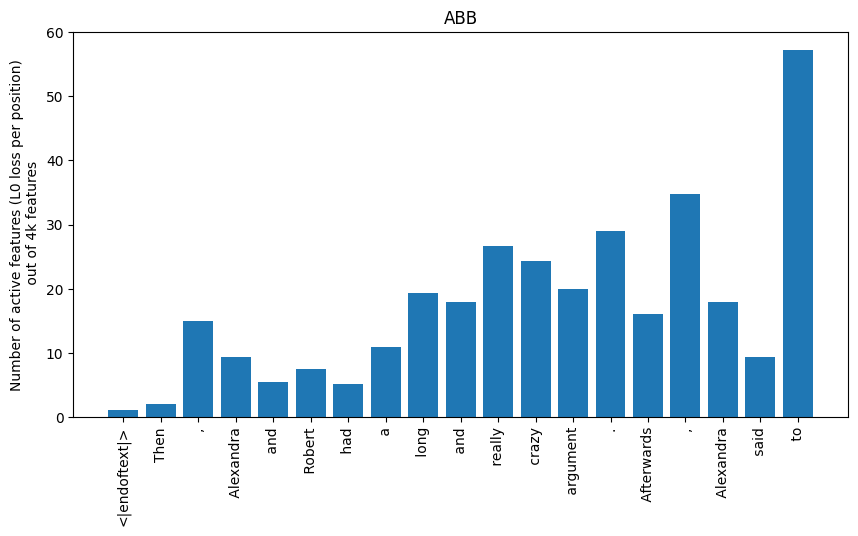

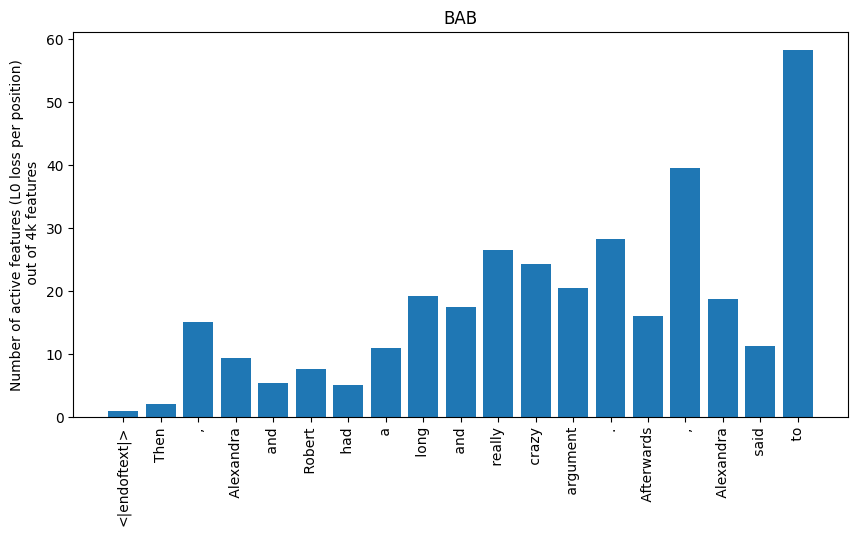

In [96]:
import matplotlib.pyplot as plt

# barplot
ioi_tokens = model.to_string(next(iter(ioi_loader)))
plt.figure(figsize=(10, 5))
plt.bar(range(abb_l0_per_pos.shape[0]), abb_l0_per_pos.cpu().numpy())
ex_text = model.to_str_tokens(ioi_tokens[0], prepend_bos=False)
plt.xticks(range(abb_l0_per_pos.shape[0]), ex_text, rotation=90)
plt.ylabel('Number of active features (L0 loss per position)\n out of 4k features')
plt.title('ABB')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(range(bab_l0_per_pos.shape[0]), bab_l0_per_pos.cpu().numpy())
ex_text = model.to_str_tokens(ioi_tokens[0], prepend_bos=False)
plt.xticks(range(bab_l0_per_pos.shape[0]), ex_text, rotation=90)
plt.ylabel('Number of active features (L0 loss per position)\n out of 4k features')
plt.title('BAB')
plt.show()

In [7]:
from tqdm import tqdm

def get_alive_neurons(encoder, activation_loader, n_activations=1e6, threshold=1e-6):
    n_batches = n_activations // encoder.cfg['batch_size'] - 1
    n_active_per_neuron = torch.zeros(encoder.cfg['d_hidden']).cuda()
    n_total = 0
    for i, batch in tqdm(enumerate(activation_loader)):
        batch = batch.cuda()
        feature_acts = encoder.encoder(batch) # [batch, d_hidden]
        n_active_per_neuron += (feature_acts > 1e-7).sum(dim=0)
        n_total += feature_acts.shape[0]
        if i >= n_batches:
            break
    frequencies = n_active_per_neuron / n_total
    # get indices of neurons that are more active than threshold
    indices = torch.where(frequencies > threshold)
    return indices[0]

In [14]:
from activation_buffer import Buffer

encoder.cfg['buffer_size'] = 1e6
buffer = Buffer(
    model.cuda(),
    text_dataset_loader,
    **encoder.cfg
)

Moving model to device:  cuda
setting up now
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to 

In [16]:
encoder.cuda()
idx_alive = get_alive_neurons(encoder, buffer)
print('% of neurons alive: ', len(idx_alive) / encoder.cfg['d_hidden'])

241it [00:06, 37.75it/s]

new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch ad

241it [00:25, 37.75it/s]

new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer


243it [00:35,  6.83it/s]


% of neurons alive:  0.628662109375


In [26]:
def get_ioi_neurons(encoder, ioi_loader, n_activations=1e6, threshold=1e-6):
    n_batches = n_activations // encoder.cfg['batch_size'] - 1
    n_active_per_neuron = torch.zeros(encoder.cfg['d_hidden']).cuda()
    n_total = 0
    for i, batch in tqdm(enumerate(ioi_loader)):
        batch = batch.cuda()
        _, cache = model.run_with_cache(batch)
        actv = cache[encoder.cfg['actv_name']][:, -1, cfg['head'], :]  # activations at END token of IOI prompts
        feature_acts = encoder.encoder(actv) # [batch, d_hidden]
        n_active_per_neuron += (feature_acts > 1e-7).sum(dim=0)
        n_total += feature_acts.shape[0]
        if i >= n_batches:
            break
    frequencies = n_active_per_neuron / n_total
    # get indices of neurons that are more active than threshold
    indices = torch.where(frequencies > threshold)
    return indices[0]

In [93]:
idx_ioi_features = get_ioi_neurons(encoder, ioi_loader, 1e7)
print('% of alive neurons that fire on END token of IOI prompts: ', len(idx_ioi_features) / len(idx_alive))
print('Number of neurons that fire on END token of IOI prompts: ', len(idx_ioi_features))

63it [00:04, 12.93it/s]

% of alive neurons that fire on END token of IOI prompts:  0.6983559685489635
Number of neurons that fire on END token of IOI prompts:  977


In [94]:
# save features
torch.save(idx_ioi_features, 'idx_ioi_features.pt')

In [18]:
idx_ioi_features = torch.load('idx_ioi_features.pt')

In [19]:
import joblib

codes = joblib.load('data/georg_codes_dict_webtext.joblib')
names = joblib.load('data/names.joblib')
z_l9h9 = codes[('z', 9, 9)]

def cosine_sim(dict_v, name_v):
    ab = einops.einsum(dict_v, name_v, 'd_hidden d_head, n_names d_head -> d_hidden n_names')
    # dict_v all have unit norm
    name_norm = name_v.norm(dim=-1)
    return ab / name_norm

In [100]:
import random
import pandas as pd

names_filter = lambda name_: encoder.cfg['actv_name'] in name_

def io_pos_score(feature_idx, template_tokens, test_name, names, n1_idx, n2_idx, n3_idx, end_idx, n_random_samples = 10, mode='count'):
    # random samples: test a random combination of names rather than all as all would take too long
    # mode: count or sum. count: count (in percent) how many times the feature is active, sum: sum the attention contributions directly
    df = pd.DataFrame(data={
        'abb': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'bab': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'aba': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'baa': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'abb_sum': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'bab_sum': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'aba_sum': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'baa_sum': torch.zeros_like(feature_idx).float().cpu().numpy(),
    })
    n_examples = 0
    for n_pos in [0, 1]:
        for n in names:
            if n_pos == 0:
                n1, n2 = test_name, n
            else:
                n1, n2 = n, test_name
            for n3 in [n1, n2]:
                template_tokens[0, n1_idx] = model.to_single_token(' ' + n1)
                template_tokens[0, n2_idx] = model.to_single_token(' ' + n2)
                template_tokens[0, n3_idx] = model.to_single_token(' ' + n3)
                _, cache = model.run_with_cache(template_tokens)
                actv = cache[encoder.cfg['actv_name']][:, -1, cfg['head'], :]  # activations at END token of IOI prompts
                feature_acts = encoder.encoder(actv) # [batch, d_hidden]
                feature_acts = feature_acts[:, feature_idx]
                
                act_score = (feature_acts > 0).sum(dim=0).cpu().numpy()
                act_score_sum = feature_acts.sum(dim=0).cpu().numpy()
                
                # if ABB or ABA
                if n1 == test_name:
                    if n3 == n1: # ABA
                        df['aba'] += act_score
                        df['aba_sum'] += act_score_sum
                    else: # ABB
                        df['abb'] += act_score
                        df['abb_sum'] += act_score_sum
                # if BAB or BBA
                else:
                    if n3 == n1: # BAB
                        df['bab'] += act_score
                        df['bab_sum'] += act_score_sum
                    else: # BBA
                        df['baa'] += act_score
                        df['baa_sum'] += act_score_sum
                n_examples += feature_acts.shape[0]
    return df / (n_examples // 4)
n1_idx, n2_idx, n3_idx, end_idx = 3, 5, 16, 18
#io_pos_scores = io_pos_score(idx_ioi_features, tokens, test_name='Robert', names=names, n1_idx=n1_idx, n2_idx=n2_idx, n3_idx=n3_idx, end_idx=end_idx)

In [101]:
df = pd.DataFrame()
for test_name in tqdm(names):
    io_pos_scores = io_pos_score(idx_ioi_features, tokens, test_name, names, n1_idx, n2_idx, n3_idx, end_idx)
    io_pos_scores['feature'] = idx_ioi_features.cpu().numpy()
    io_pos_scores['name'] = test_name
    df = pd.concat([df, io_pos_scores])
# save df
df.to_csv('io_pos_scores_z_l9h9.csv')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [2:27:19<00:00, 40.92s/it]


In [20]:
import pandas as pd

df = pd.read_csv('io_pos_scores_z_l9h9.csv')

In [21]:
df['contains_name'] = df['abb'] * df['aba'] * df['bab'] * df['baa']
df['is_subject'] = df['aba'] * df['baa'] - (df['bab'] + df['abb'])
df['is_io'] = df['bab'] * df['abb'] - (df['aba'] + df['baa'])
df['io_pos_first'] = df['abb'] * df['baa'] - (df['aba'] + df['bab'])
df['io_pos_second'] = df['bab'] * df['aba'] - (df['abb'] + df['baa'])
df['name_is_first'] = df['aba'] * df['abb'] - (df['bab'] + df['baa'])
df['name_is_second'] = df['bab'] * df['baa'] - (df['aba'] + df['abb'])
df['name_is_first_and_subject'] = df['aba'] - (df['abb'] + df['bab'] + df['baa'])
df['name_is_second_and_subject'] = df['baa'] - (df['abb'] + df['bab'] + df['aba'])
df['name_is_first_and_io'] = df['abb'] - (df['aba'] + df['bab'] + df['baa'])
df['name_is_second_and_io'] = df['bab'] - (df['abb'] + df['aba'] + df['baa'])
print('contains name', (df['contains_name'] > 0.25).sum() / len(df.name.unique()))
print('is subject', (df['is_subject'] > 0.25).sum() / len(df.name.unique()))
print('is io', (df['is_io'] > 0.25).sum() / len(df.name.unique()))
print('io_pos_first', (df['io_pos_first'] > 0.25).sum() / len(df.name.unique()))
print('io_pos_second', (df['io_pos_second'] > 0.25).sum() / len(df.name.unique()))
print('name_is_first', (df['name_is_first'] > 0.25).sum() / len(df.name.unique()))
print('name_is_second', (df['name_is_second'] > 0.25).sum() / len(df.name.unique()))
print('name_is_first_and_subject', (df['name_is_first_and_subject'] > 0.25).sum() / len(df.name.unique()))
print('name_is_second_and_subject', (df['name_is_second_and_subject'] > 0.25).sum() / len(df.name.unique()))
print('name_is_first_and_io', (df['name_is_first_and_io'] > 0.25).sum() / len(df.name.unique()))
print('name_is_second_and_io', (df['name_is_second_and_io'] > 0.25).sum() / len(df.name.unique()))

contains name 2.759259259259259
is subject 0.20833333333333334
is io 48.157407407407405
io_pos_first 0.0
io_pos_second 0.027777777777777776
name_is_first 0.0
name_is_second 0.0
name_is_first_and_subject 0.23148148148148148
name_is_second_and_subject 0.24074074074074073
name_is_first_and_io 4.99537037037037
name_is_second_and_io 6.75462962962963


In [38]:
df

Unnamed: 0       abb       bab       aba       baa  feature       name  \
0              0  0.995370  0.995370  0.472222  0.296296        0  Sebastian   
1              1  0.000000  0.000000  0.023148  0.018519        4  Sebastian   
2              2  0.000000  0.000000  0.018519  0.018519       16  Sebastian   
3              3  0.000000  0.000000  0.000000  0.000000       18  Sebastian   
4              4  0.000000  0.000000  0.000000  0.000000       22  Sebastian   
...          ...       ...       ...       ...       ...      ...        ...   
9855         981  0.000000  0.000000  0.004630  0.004630     8158        Ian   
9856         982  0.342593  0.638889  0.282407  0.259259     8161        Ian   
9857         983  0.000000  0.000000  0.000000  0.000000     8166        Ian   
9858         984  0.000000  0.000000  0.000000  0.000000     8172        Ian   
9859         985  0.000000  0.000000  0.000000  0.000000     8184        Ian   

      contains_name  is_subject     is_io  io_pos_first  io_pos_second  \
0          0.138625   -1.850823  0.222244     -1.172668      -0.821631   
1          0.000000    0.000429 -0.041667     -0.023148      -0.018519   
2          0.000000    0.000343 -0.037037     -0.018519      -0.018519   
3          0.000000    0.000000  0.000000      0.000000       0.000000   
4          0.000000    0.000000  0.000000      0.000000       0.000000   
...             ...         ...       ...           ...            ...   
9855       0.000000    0.000021 -0.009259     -0.004630      -0.004630   
9856       0.016026   -0.908265 -0.322788     -0.832476      -0.421425   
9857       0.000000    0.000000  0.000000      0.000000       0.000000   
9858       0.000000    0.000000  0.000000      0.000000       0.000000   
9859       0.000000    0.000000  0.000000      0.000000       0.000000   

      name_is_first  name_is_second  name_is_first_and_subject  \
0         -0.821631       -1.172668                  -1.814815   
1         -0.018519       -0.023148                   0.004630   
2         -0.018519       -0.018519                   0.000000   
3          0.000000        0.000000                   0.000000   
4          0.000000        0.000000                   0.000000   
...             ...             ...                        ...   
9855      -0.004630       -0.004630                   0.000000   
9856      -0.801397       -0.459362                  -0.958333   
9857       0.000000        0.000000                   0.000000   
9858       0.000000        0.000000                   0.000000   
9859       0.000000        0.000000                   0.000000   

      name_is_second_and_subject  name_is_first_and_io  name_is_second_and_io  
0                      -2.166667             -0.768519              -0.768519  
1                      -0.004630             -0.041667              -0.041667  
2                       0.000000             -0.037037              -0.037037  
3                       0.000000              0.000000               0.000000  
4                       0.000000              0.000000               0.000000  
...                          ...                   ...                    ...  
9855                    0.000000             -0.009259              -0.009259  
9856                   -1.004630             -0.837963              -0.245370  
9857                    0.000000              0.000000               0.000000  
9858                    0.000000              0.000000               0.000000  
9859                    0.000000              0.000000               0.000000  

[9860 rows x 18 columns]

In [104]:
from tqdm import tqdm

n1_idx, n2_idx, n3_idx, end_idx = 3, 5, 16, 18
n_names = len(names)
mentions = torch.zeros(len(names[:n_names]), len(idx_ioi_features), device='cuda')
mentions_add = torch.zeros(len(names[:n_names]), len(idx_ioi_features), device='cuda')
for n1 in names[:n_names]:
    for n2 in tqdm(names[:n_names]):
        for n3 in [n1, n2]:
            tokens[0, n1_idx] = model.to_single_token(' ' + n1)
            tokens[0, n2_idx] = model.to_single_token(' ' + n2)
            tokens[0, n3_idx] = model.to_single_token(' ' + n3)
            _, cache = model.run_with_cache(tokens.cuda())
            actv = cache[encoder.cfg['actv_name']][:, -1, cfg['head'], :]  # activations at END token of IOI prompts
            feature_acts = encoder.encoder(actv) # [batch, d_hidden]
            feature_acts = feature_acts[:, idx_ioi_features]
            
            # if n1 is io
            if n2 == n3:
                mentions[names.index(n1), :] += (feature_acts > 0).sum(dim=0)
                mentions_add[names.index(n1), :] += feature_acts.sum(dim=0)
            # if n2 is io
            else:
                mentions[names.index(n2), :] += (feature_acts > 0).sum(dim=0)
                mentions_add[names.index(n2), :] += feature_acts.sum(dim=0)
# save
torch.save(mentions, 'mentions_z_l9h9.pt')
torch.save(mentions_add, 'mentions_add_z_l9h9.pt')

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 172/216 [00:16<00:04, 10.97it/s]

In [105]:
mentions

In [22]:
mentions = torch.load('mentions_z_l9h9.pt')
mentions_add = torch.load('mentions_add_z_l9h9.pt')
n_names = mentions.shape[0]
mentions.shape, mentions_add.shape

(torch.Size([216, 977]), torch.Size([216, 977]))

In [23]:
k = 10
top_k_sensitivity = torch.zeros([k, len(idx_ioi_features)], device='cuda', dtype=torch.float32)
top_k_specificity = torch.zeros([k, len(idx_ioi_features)], device='cuda', dtype=torch.float32)
top_k_precision = torch.zeros([k, len(idx_ioi_features)], device='cuda', dtype=torch.float32)
n_true_positives = 2 * n_names

for i in range(len(idx_ioi_features)):
    top_1_name = mentions[:, i].argmax()
    top_k_names = mentions[:, i].topk(k).indices
    for j in range(k):
        top_k_sensitivity[j, i] = mentions[top_k_names[:j+1], i].sum() / (n_true_positives * (j+1))
        top_k_specificity[j, i] = 1 - (mentions[:, i].sum() - mentions[top_k_names[:j+1], i].sum()) / (n_true_positives * (n_names - (j+1)))
        top_k_precision[j, i] = mentions[top_k_names[:j+1], i].sum() / mentions[:, i].sum()
    #top_1_sensitivity[i] = mentions[top_1_name, i] / n_true_positives
    #top_1_specificity[i] = (mentions[:, i].sum() - mentions[top_1_name, i]) / (n_true_positives * (n_names - 1))

In [24]:
import pandas as pd

df_all_k = pd.DataFrame()

for i in range(top_k_sensitivity.shape[0]):  # Loop through each k
    # For each k, create a DataFrame with features, sensitivity, and specificity
    df_k = pd.DataFrame({
        'feature': idx_ioi_features.cpu().numpy(),
        f'sensitivity_k{i+1}': top_k_sensitivity[i].cpu().numpy(),
        f'specificity_k{i+1}': top_k_specificity[i].cpu().numpy(),
        f'precision_k{i+1}': top_k_precision[i].cpu().numpy(),
    })
    # Concatenate this DataFrame with the main one
    if df_all_k.empty:
        df_all_k = df_k
    else:
        # Merge on 'feature' to add new columns for each k
        df_all_k = pd.merge(df_all_k, df_k, on='feature', how='outer')

# Assuming 'df' is your second DataFrame and contains a column 'feature_id'
# Merge df_all_k with df on the 'feature' and 'feature_id'
result_df = pd.merge(df_all_k, df, left_on='feature', right_on='feature', how='inner')
result_df

feature  sensitivity_k1  specificity_k1  precision_k1  sensitivity_k2  \
0             0        1.000000        0.672911      0.014021        1.000000   
1             0        1.000000        0.672911      0.014021        1.000000   
2             0        1.000000        0.672911      0.014021        1.000000   
3             0        1.000000        0.672911      0.014021        1.000000   
4             0        1.000000        0.672911      0.014021        1.000000   
...         ...             ...             ...           ...             ...   
211027     8166        0.136574        0.999472      0.546296        0.116898   
211028     8166        0.136574        0.999472      0.546296        0.116898   
211029     8166        0.136574        0.999472      0.546296        0.116898   
211030     8166        0.136574        0.999472      0.546296        0.116898   
211031     8166        0.136574        0.999472      0.546296        0.116898   

        specificity_k2  precision_k2  sensitivity_k3  specificity_k3  \
0             0.676056      0.028041         1.00000        0.679230   
1             0.676056      0.028041         1.00000        0.679230   
2             0.676056      0.028041         1.00000        0.679230   
3             0.676056      0.028041         1.00000        0.679230   
4             0.676056      0.028041         1.00000        0.679230   
...                ...           ...             ...             ...   
211027        0.999924      0.935185         0.08179        0.999978   
211028        0.999924      0.935185         0.08179        0.999978   
211029        0.999924      0.935185         0.08179        0.999978   
211030        0.999924      0.935185         0.08179        0.999978   
211031        0.999924      0.935185         0.08179        0.999978   

        precision_k3  ...  is_subject     is_io  io_pos_first  io_pos_second  \
0           0.042062  ...   -1.850823  0.222244     -1.172668      -0.821631   
1           0.042062  ...    0.051119 -0.453704     -0.208333      -0.245370   
2           0.042062  ...   -0.052641 -0.675926     -0.569444      -0.202503   
3           0.042062  ...    0.077889 -0.578704     -0.328704      -0.253129   
4           0.042062  ...    0.091628 -0.611111     -0.347222      -0.263889   
...              ...  ...         ...       ...           ...            ...   
211027      0.981481  ...   -0.023148 -0.009174     -0.027778      -0.004458   
211028      0.981481  ...    0.000043 -0.013889     -0.009259      -0.004630   
211029      0.981481  ...    0.000000  0.000000      0.000000       0.000000   
211030      0.981481  ...    0.000000 -0.009259     -0.009259       0.000000   
211031      0.981481  ...    0.000000  0.000000      0.000000       0.000000   

        name_is_first  name_is_second  name_is_first_and_subject  \
0           -0.821631       -1.172668                  -1.814815   
1           -0.245370       -0.208333                  -0.037037   
2           -0.430556       -0.363897                  -0.023148   
3           -0.259259       -0.322895                   0.064815   
4           -0.263889       -0.347222                   0.083333   
...               ...             ...                        ...   
211027      -0.018476       -0.013889                  -0.013889   
211028      -0.004630       -0.009259                   0.004630   
211029       0.000000        0.000000                   0.000000   
211030       0.000000       -0.009259                   0.009259   
211031       0.000000        0.000000                   0.000000   

        name_is_second_and_subject  name_is_first_and_io  \
0                        -2.166667             -0.768519   
1                         0.037037             -0.453704   
2                        -0.300926             -0.837963   
3                        -0.074074             -0.583333   
4                        -0.083333             -0.611111   
...                            .

In [98]:
f_df = df_all_k.copy()
k = 0
f_df[(f_df[f'sensitivity_k{i+1}'] > 0.8) & (f_df[f'precision_k{k+1}'] > 0.8)]

Empty DataFrame
Columns: [feature, sensitivity_k1, specificity_k1, precision_k1, sensitivity_k2, specificity_k2, precision_k2, sensitivity_k3, specificity_k3, precision_k3, sensitivity_k4, specificity_k4, precision_k4, sensitivity_k5, specificity_k5, precision_k5, sensitivity_k6, specificity_k6, precision_k6, sensitivity_k7, specificity_k7, precision_k7, sensitivity_k8, specificity_k8, precision_k8, sensitivity_k9, specificity_k9, precision_k9, sensitivity_k10, specificity_k10, precision_k10]
Index: []

[0 rows x 31 columns]

In [100]:
f_df = df_all_k.copy()
for k in range(10):
    f = f_df[(f_df[f'sensitivity_k{k+1}'] > 0.8) & (f_df[f'precision_k{k+1}'] > 0.8)]
    print(f'k={k+1}: {len(f)}')
    # exclude f
    f_df = f_df[~f_df.feature.isin(f.feature)]

k=1: 34
k=2: 24
k=3: 8
k=4: 6
k=5: 1
k=6: 0
k=7: 3
k=8: 2
k=9: 0
k=10: 3


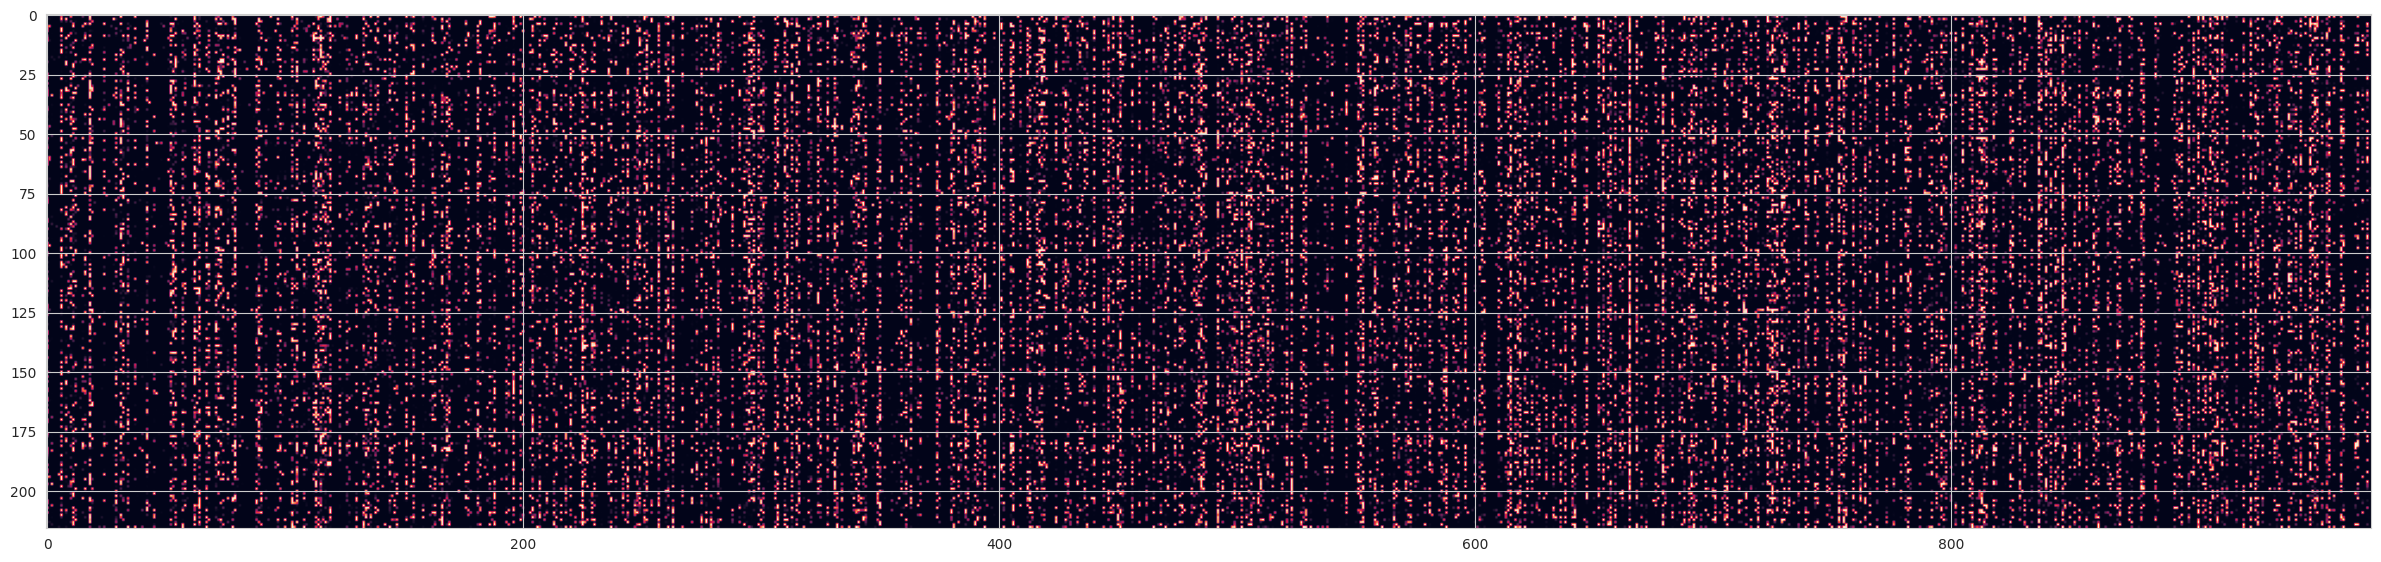

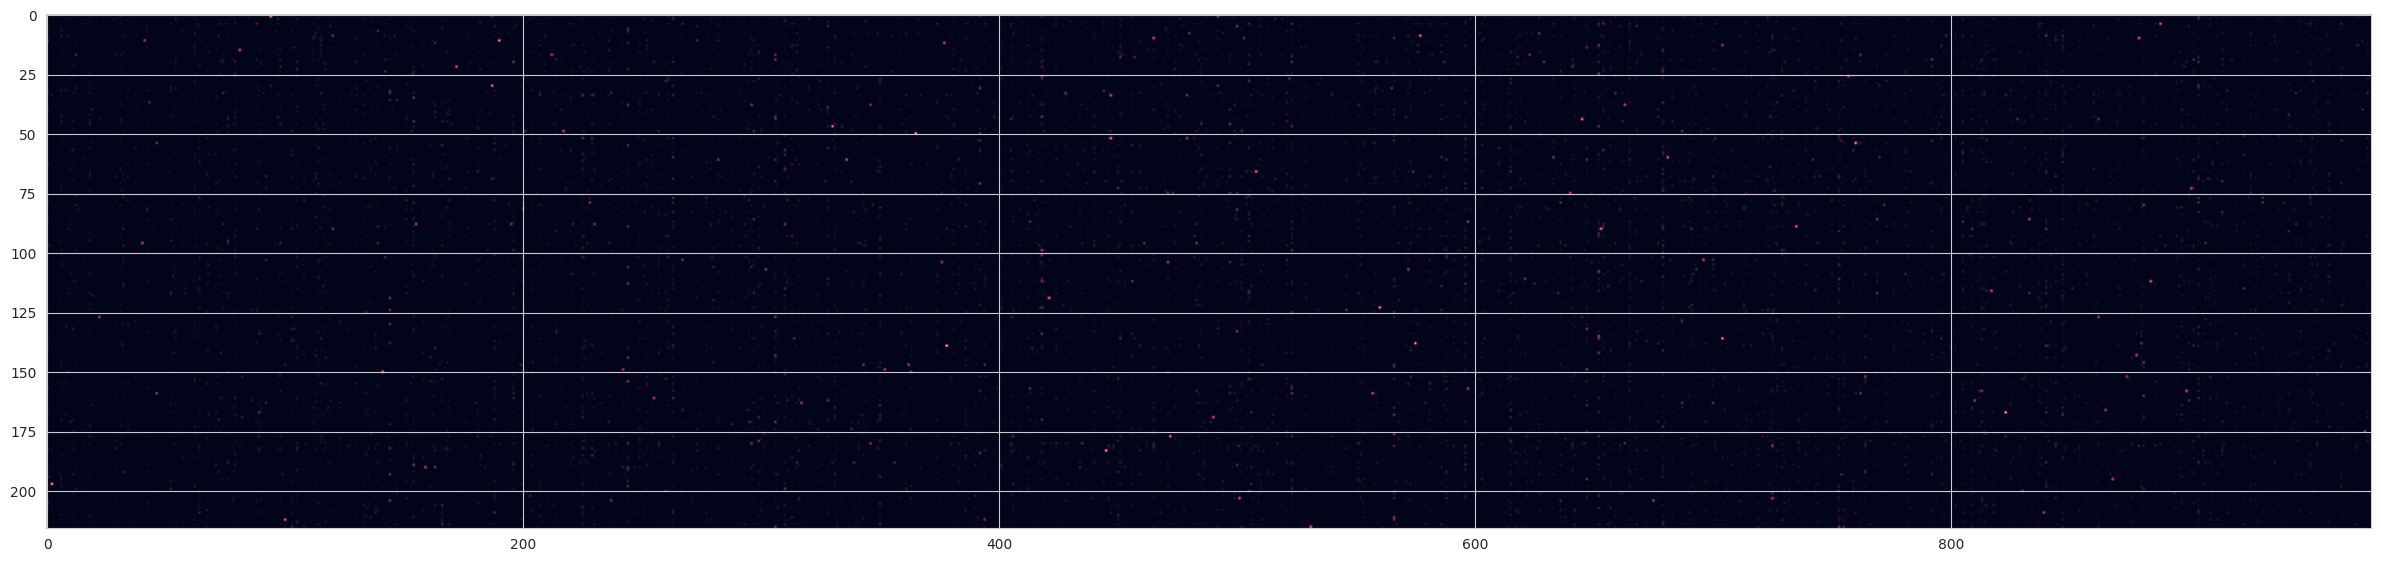

In [108]:
plt.figure(figsize=(30, 10))
plt.imshow(mentions.cpu().numpy())
plt.show()
plt.figure(figsize=(30, 10))
plt.imshow(mentions_add.cpu().numpy())
plt.show()

In [113]:
mentions_add.mean()

tensor(7.9169, device='cuda:0')

(0.0, 50.0)

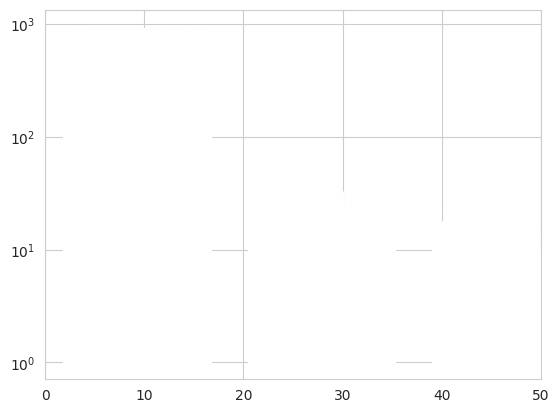

In [114]:
plt.hist(mentions_add.cpu(), bins=100)
plt.yscale('log')
plt.xlim(0, 50)

(array([4.730e+03, 4.338e+03, 3.156e+03, 2.243e+03, 1.737e+03, 1.247e+03,
        8.460e+02, 6.340e+02, 4.730e+02, 3.650e+02, 2.780e+02, 1.900e+02,
        1.500e+02, 1.000e+02, 7.400e+01, 6.700e+01, 4.800e+01, 4.600e+01,
        4.400e+01, 3.500e+01, 3.200e+01, 2.200e+01, 3.000e+01, 2.300e+01,
        1.500e+01, 1.300e+01, 7.000e+00, 1.200e+01, 1.100e+01, 1.000e+01,
        1.100e+01, 1.100e+01, 1.100e+01, 9.000e+00, 6.000e+00, 7.000e+00,
        6.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 5.000e+00, 4.000e+00,
        5.000e+00, 2.000e+00, 0.000e+00, 8.000e+00, 1.000e+00, 2.000e+00,
        5.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 1.000e+0

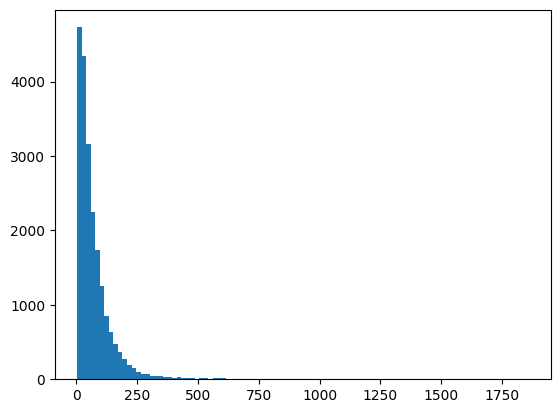

In [33]:
mentions_weighted = mentions_filtered * mentions_add
plt.hist(mentions_weighted[mentions_weighted > 0].cpu(), bins=100)

(array([191., 125.,  70.,  32.,  21.,  10.,  12.,   8.,   7.,   4.,   9.,
          2.,  12.,   1.,   3.,   4.,   6.,  11.,   3.,   9.,   6.,   0.,
         11.,  13.,   7.,  12.,  10.,   7.,   6.,  10.,  11.,   9.,   6.,
         11.,  17.,   9.,  11.,  13.,   5.,  14.,  10.,   9.,   0.,   8.,
          7.,   8.,   6.,  12.,  11.,  10.,   6.,   8.,   8.,   5.,   4.,
         16.,   6.,  10.,   3.,   7.,   5.,   9.,   2.,   7.,   0.,   4.,
          3.,   1.,   3.,   8.,   6.,   1.,   7.,   6.,   3.,   2.,   1.,
          3.,   4.,   1.,   2.,   0.,   4.,   1.,   1.,   0.,   0.,   1.,
          0.,   2.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

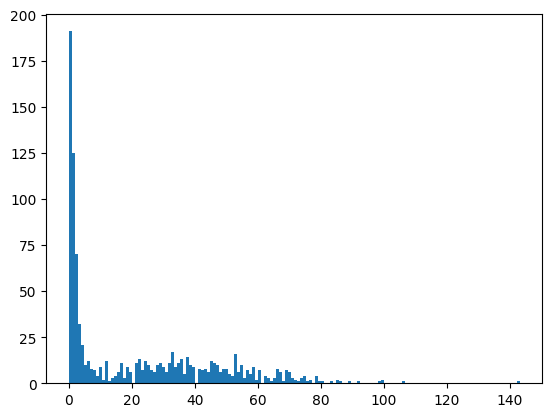

In [26]:
# make a histogram for how many names a feature is active for but exclude name that are not reliably activating a feature
import matplotlib.pyplot as plt
mentions_filtered = (mentions > 0.5 * n_names * 2)
names_per_feature = mentions_filtered.sum(dim=0)
assert names_per_feature.shape[0] == len(idx_ioi_features)
plt.hist(names_per_feature.cpu().numpy(), bins=150)

(array([292., 126.,  69.,  48.,  30.,  34.,  43.,  15.,  22.,  27.,  29.,
         25.,  17.,  20.,  20.,  19.,  16.,  15.,  10.,  13.,   9.,   7.,
          7.,   9.,   8.,   9.,   5.,   4.,   0.,   2.,   5.,   2.,   1.,
          0.,   2.,   2.,   1.,   0.,   1.,   1.,   0.,   2.,   1.,   2.,
          2.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60.]),
 <BarContainer object of 60 artists>)

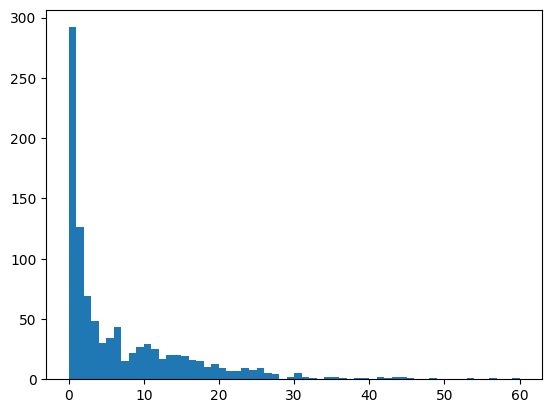

In [35]:
# make a histogram for how many names a feature is active for but exclude name that are not reliably activating a feature
import matplotlib.pyplot as plt

mentions_filtered = (mentions_weighted > 80)
names_per_feature = mentions_filtered.sum(dim=0)
assert names_per_feature.shape[0] == len(idx_ioi_features)
plt.hist(names_per_feature.cpu().numpy(), bins=60)

In [36]:
for i, feature_num in enumerate(names_per_feature):
    if feature_num < 5:
        continue
    feature_idx = idx_ioi_features[i]
    # list most active names
    topk_names = mentions[:, i].topk(feature_num).indices
    topk_names = [names[j] for j in topk_names]
    print(f'Feature {feature_idx}: {feature_num} names: {topk_names}')
    

Feature 0: 44 names: ['Sebastian', 'Caroline', 'Brian', 'Rebecca', 'Robert', 'Joshua', 'Deb', 'Josh', 'Brooke', 'Brad', 'Benjamin', 'Kim', 'Wyatt', 'Jake', 'Blake', 'Jason', 'Chase', 'Caleb', 'Andrew', 'Ben', 'Jennifer', 'Bill', 'Adam', 'Jonathan', 'Rachel', 'Brandon', 'Bella', 'Rob', 'Bailey', 'Jacob', 'Scarlett', 'Isaac', 'Justin', 'Jeff', 'Joe', 'Frank', 'Sarah', 'Owen', 'Charlotte', 'Harper', 'Keith', 'Noah', 'Kate', 'Todd']
Feature 40: 27 names: ['Peter', 'Cameron', 'Ian', 'Ken', 'Liam', 'David', 'Caroline', 'Rebecca', 'Kent', 'Oliver', 'Julian', 'Kate', 'James', 'Nicholas', 'Alice', 'Josh', 'Andy', 'Victoria', 'Isabel', 'Zoe', 'Stella', 'Katherine', 'Bella', 'Cooper', 'Chris', 'Alexis', 'Alan']
Feature 83: 5 names: ['Ian', 'Scott', 'Justin', 'Steven', 'Emily']
Feature 90: 6 names: ['Eleanor', 'Todd', 'Andrea', 'Ashley', 'Emily', 'Ethan']
Feature 95: 17 names: ['Kate', 'Piper', 'Ray', 'Tyler', 'Max', 'Ethan', 'Robert', 'Kevin', 'Oliver', 'Audrey', 'Parker', 'Christopher', 'Patrick

In [30]:
for i, feature_num in enumerate(names_per_feature):
    if feature_num > 5:
        continue
    if feature_num < 2:
        continue
    feature_idx = idx_ioi_features[i]
    # list most active names
    topk_names = mentions[:, i].topk(feature_num).indices
    topk_names = [names[j] for j in topk_names]
    print(f'Feature {feature_idx}: {feature_num} names: {topk_names}')
    

Feature 16: 4 names: ['Aaron', 'Joshua', 'Brandon', 'Elijah']
Feature 187: 2 names: ['Tom', 'Thomas']
Feature 226: 2 names: ['Susan', 'Christopher']
Feature 260: 2 names: ['Tyler', 'Chris']
Feature 284: 2 names: ['Jeremiah', 'Joshua']
Feature 429: 3 names: ['Frank', 'Brandon', 'Grant']
Feature 442: 2 names: ['Lauren', 'Elijah']
Feature 448: 2 names: ['Dan', 'Daniel']
Feature 479: 4 names: ['Patrick', 'Anthony', 'Larry', 'Mark']
Feature 661: 2 names: ['Luke', 'Matthew']
Feature 663: 3 names: ['Alexander', 'Andrew', 'Alex']
Feature 668: 2 names: ['Claire', 'Christian']
Feature 675: 2 names: ['Ross', 'Bill']
Feature 745: 3 names: ['Jack', 'Jackson', 'Tyler']
Feature 788: 2 names: ['Ray', 'Dylan']
Feature 822: 2 names: ['Christopher', 'Chris']
Feature 878: 2 names: ['John', 'Mary']
Feature 914: 3 names: ['Christopher', 'Jessica', 'Leo']
Feature 1008: 2 names: ['Justin', 'Ian']
Feature 1024: 3 names: ['Nathaniel', 'William', 'Christopher']
Feature 1061: 2 names: ['Sebastian', 'Mark']
Featur

In [58]:
result_df[(result_df.sensitivity_k1 > 0.95) & (result_df.precision_k1 > 0.95) & (result_df.feature==1577)]

feature  sensitivity_k1  specificity_k1  precision_k1  sensitivity_k2  \
43416     1577        0.986111             1.0           1.0        0.493056   
43417     1577        0.986111             1.0           1.0        0.493056   
43418     1577        0.986111             1.0           1.0        0.493056   
43419     1577        0.986111             1.0           1.0        0.493056   
43420     1577        0.986111             1.0           1.0        0.493056   
...        ...             ...             ...           ...             ...   
43627     1577        0.986111             1.0           1.0        0.493056   
43628     1577        0.986111             1.0           1.0        0.493056   
43629     1577        0.986111             1.0           1.0        0.493056   
43630     1577        0.986111             1.0           1.0        0.493056   
43631     1577        0.986111             1.0           1.0        0.493056   

       specificity_k2  precision_k2  sensitivity_k3  specificity_k3  \
43416             1.0           1.0        0.328704             1.0   
43417             1.0           1.0        0.328704             1.0   
43418             1.0           1.0        0.328704             1.0   
43419             1.0           1.0        0.328704             1.0   
43420             1.0           1.0        0.328704             1.0   
...               ...           ...             ...             ...   
43627             1.0           1.0        0.328704             1.0   
43628             1.0           1.0        0.328704             1.0   
43629             1.0           1.0        0.328704             1.0   
43630             1.0           1.0        0.328704             1.0   
43631             1.0           1.0        0.328704             1.0   

       precision_k3  ...  is_subject     is_io  io_pos_first  io_pos_second  \
43416           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   
43417           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   
43418           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   
43419           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   
43420           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   
...             ...  ...         ...       ...           ...            ...   
43627           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   
43628           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   
43629           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   
43630           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   
43631           1.0  ...    0.000021 -0.009259      -0.00463       -0.00463   

       name_is_first  name_is_second  name_is_first_and_subject  \
43416       -0.00463        -0.00463                        0.0   
43417       -0.00463        -0.00463                        0.0   
43418       -0.00463        -0.00463                        0.0   
43419       -0.00463        -0.00463                        0.0   
43420       -0.00463        -0.00463                        0.0   
...              ...             ...                        ...   
43627       -0.00463        -0.00463                        0.0   
43628       -0.00463        -0.00463                        0.0   
43629       -0.00463        -0.00463                        0.0   
43630       -0.00463        -0.00463                        0.0   
43631       -0.00463        -0.00463                        0.0   

       name_is_second_and_subject  name_is_first_and_io  name_is_second_and_io  
43416                         0.0             -0.009259              -0.009259  
43417                         0.0             -0.009259              -0.009259  
43418                         0.0             -0.009259              -0.009259  
43419                         0.0             -0.009259              -0.009259  
43420                         0.0 

In [78]:
greg_feature_idx = result_df[(result_df.name=='Greg') & (result_df.is_io > 0.5)].feature

In [29]:
features = df_all_k[(df_all_k.precision_k1 > 0.95) & (df_all_k.sensitivity_k1 > 0.95)].feature[:20]

In [53]:
# index of idx_ioi_features where it's value is 1570
(idx_ioi_features == 3078).nonzero()

tensor([[377]], device='cuda:0')

In [66]:
# what index is Greg in names
list(names).index('Greg')

49

In [73]:
encoder.b_dec[1577]

IndexError: too many indices for tensor of dimension 1

In [83]:
encoder.W_dec[torch.tensor(greg_feature_idx)]

ValueError: could not determine the shape of object type 'Series'

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 13.,
         2.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.85603279, -0.77070904, -0.68538535, -0.6000616 , -0.51473784,
        -0.42941415, -0.3440904 , -0.25876668, -0.17344294, -0.08811922,
        -0.00279549,  0.08252824,  0.16785197,  0.25317571,  0.33849943,
         0.42382318,  0.50914687,  0.59447062,  0.67979437,  0.76511806,
         0.85044181]),
 <BarContainer object of 20 artists>)

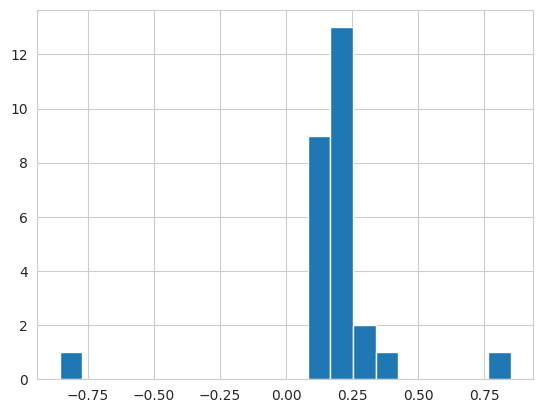

In [85]:
sims = cosine_sim(encoder.W_dec[list(greg_feature_idx)],z_l9h9[('io',)][49].view(1, -1))
import matplotlib.pyplot as plt

plt.hist(sims.cpu().numpy(), bins=20)

In [90]:
argmin, argmax = sims.argmin(), sims.argmax()
def v_cosine(a, b):
    return torch.dot(a, b) / (a.norm() * b.norm())
v_cosine(encoder.W_dec[list(greg_feature_idx)][argmin], encoder.W_dec[list(greg_feature_idx)][argmax])

tensor(-0.7021, device='cuda:0')

In [79]:
idx_ioi_features = df.feature.unique()
idx_ioi_features

array([   0,    4,   16,   18,   22,   29,   40,   53,   73,   83,   90,
         95,  101,  122,  131,  137,  144,  145,  150,  169,  174,  187,
        202,  217,  218,  226,  260,  275,  284,  303,  306,  341,  353,
        370,  380,  382,  384,  388,  405,  419,  420,  429,  431,  438,
        442,  444,  447,  448,  450,  452,  456,  461,  465,  478,  479,
        482,  489,  493,  494,  498,  505,  509,  517,  521,  527,  532,
        537,  541,  544,  559,  565,  577,  583,  584,  597,  605,  608,
        611,  623,  628,  639,  641,  649,  653,  661,  663,  667,  668,
        674,  694,  701,  712,  718,  739,  742,  745,  755,  764,  768,
        772,  777,  779,  788,  798,  819,  822,  835,  841,  850,  861,
        875,  878,  886,  905,  914,  933,  945,  947,  955,  983,  985,
        993,  996,  998, 1004, 1008, 1024, 1029, 1034, 1047, 1061, 1067,
       1084, 1090, 1091, 1100, 1116, 1123, 1130, 1136, 1137, 1139, 1150,
       1151, 1157, 1177, 1185, 1186, 1192, 1201, 12

In [54]:
# get name of top k features
names = np.array(names)
names[torch.topk(mentions[:, 377], 20).indices.int().cpu().numpy()]

array(['Carter', 'Dean', 'Brandon', 'Jason', 'Rob', 'Eric', 'Deb', 'Carl',
       'Ray', 'Ben', 'Cole', 'Frank', 'Jackson', 'Peyton', 'Reagan',
       'Emma', 'Grace', 'Sebastian', 'Jack', 'Jeremiah'], dtype='<U11')

In [83]:
mentions[:, 201]

tensor([  0.,   0.,   0.,   0.,   1., 418.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  12.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   

In [89]:
features = df_all_k[(df_all_k.specificity_k1 > 0.95) & (df_all_k.sensitivity_k1 > 0.95)].feature[:20]

In [73]:
for i, feature_id in enumerate(idx_ioi_features):
    print(f'Feature {feature_id}: Sensitivity: {top_k_sensitivity[0, i]:.2f}, Specificity: {top_k_specificity[0, i]:.2f}', 'Top 2 Sensitivity:', top_k_sensitivity[1, i], 'Top 2 Specificity:', top_k_specificity[1, i], 'Top 3 Sensitivity:', top_k_sensitivity[2, i], 'Top 3 Specificity:', top_k_specificity[2, i], 'Top 4 Sensitivity:', top_k_sensitivity[3, i], 'Top 4 Specificity:', top_k_specificity[3, i], 'Top 5 Sensitivity:', top_k_sensitivity[4, i], 'Top 5 Specificity:', top_k_specificity[4, i])

Feature 0: Sensitivity: 1.00, Specificity: 0.73 Top 2 Sensitivity: tensor(1., device='cuda:0') Top 2 Specificity: tensor(0.7653, device='cuda:0') Top 3 Sensitivity: tensor(1., device='cuda:0') Top 3 Specificity: tensor(0.8103, device='cuda:0') Top 4 Sensitivity: tensor(0.9875, device='cuda:0') Top 4 Specificity: tensor(0.8578, device='cuda:0') Top 5 Sensitivity: tensor(0.9750, device='cuda:0') Top 5 Specificity: tensor(0.9100, device='cuda:0')
Feature 4: Sensitivity: 0.80, Specificity: 1.00 Top 2 Sensitivity: tensor(0.4125, device='cuda:0') Top 2 Specificity: tensor(0.9986, device='cuda:0') Top 3 Sensitivity: tensor(0.2833, device='cuda:0') Top 3 Specificity: tensor(1., device='cuda:0') Top 4 Sensitivity: tensor(0.2125, device='cuda:0') Top 4 Specificity: tensor(1., device='cuda:0') Top 5 Sensitivity: tensor(0.1700, device='cuda:0') Top 5 Specificity: tensor(1., device='cuda:0')
Feature 16: Sensitivity: 0.03, Specificity: 1.00 Top 2 Sensitivity: tensor(0.0125, device='cuda:0') Top 2 Sp

In [69]:
mentions[:, 0]

tensor([40.,  0.,  4.,  0.,  0., 19., 40., 37.,  0., 19., 38., 40.,  3.,  1.,
         2.,  2.,  0.,  0.,  3.,  1.], device='cuda:0')

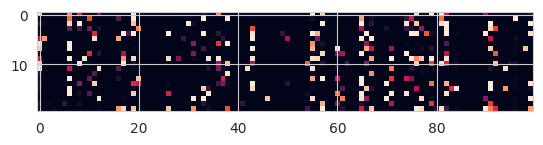

In [46]:
import matplotlib.pyplot as plt

plt.imshow(mentions.cpu().numpy()[:, :100])

In [92]:
# def get_per_src_pos_dfa_all_heads(tokens, feature_id, encoder, model):
feature_id = 2825
_, cache = model.run_with_cache(tokens)
layer = encoder.cfg["layer"]
#q = cache["q", layer] # [batch, src_pos, n_heads, d_head]
q = cache[encoder.cfg['actv_name']][:, :, encoder.cfg['head'], :]
encoder.encoder(q)[:, :, 2825] # batch seq_pos feature
k = cache["k", layer] # [batch, src_pos, n_heads, d_head]
if type(encoder.cfg['head']) == int:
    k_cat = k[:, :, encoder.cfg['head'], :]
    feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]][:, :, encoder.cfg['head']])[..., feature_id]
else:
    k_cat = einops.rearrange(v, "batch src_pos n_heads d_head -> batch src_pos (n_heads d_head)") # [batch, src_pos, n_heads*d_head]
    feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]])[..., feature_id]

scaled_dict_vectors = einops.einsum(feature_acts_per_pos, encoder.W_dec[feature_id], "batch pos, d_model -> batch pos d_model")
print(scaled_dict_vectors.shape)
per_src_pos_dfa = einops.einsum(k_cat, scaled_dict_vectors, "batch src_pos d_model, batch dest_pos d_model -> batch dest_pos src_pos")
## add autoregressive attention mask
seq_len = per_src_pos_dfa.shape[1]
mask = torch.tril(torch.ones(seq_len, seq_len), diagonal=1).to(per_src_pos_dfa.device)
per_src_pos_dfa = per_src_pos_dfa * mask# * -1
#return per_src_pos_dfa

torch.Size([1, 19, 64])


In [93]:
per_src_pos_dfa

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000, 

In [47]:
n_features_active = torch.zeros(next(iter(ioi_loader)).shape[1] + 1).cuda()
n_total = 0
model.cuda()
encoder.cuda()
i=0

names_filter = lambda name_: encoder.cfg['actv_name'] in name_

dead_neurons = torch.zeros(cfg['d_hidden']).cuda()

for batch in ioi_loader:
    # prepend bos
    batch = batch[:10]
    batch = torch.cat([torch.full((batch.shape[0], 1), 50256, device=batch.device, dtype=batch.dtype), batch], dim=1)
    _, cache = model.run_with_cache(batch.cuda(), names_filter=names_filter)
    z = cache[encoder.cfg['actv_name']][:, :, cfg['head'], :]
    feature_acts = encoder.encoder(z) # [batch, seq, d_hidden]
    dead_neurons += feature_acts.sum(dim=[0, 1])
    feature_acts = feature_acts > 1e-7
    n_features_active += feature_acts.sum(dim=[0, 2])
    n_total += feature_acts.shape[0]
    i += 1
    if i > 100:
        break
n_features_active = n_features_active / n_total
n_features_active    

Moving model to device:  cuda


tensor([ 3.0000,  0.0000,  2.0000,  1.0000,  3.2723,  3.5198,  3.7614,  3.6238,
         4.8515,  9.7713, 12.0564,  7.0594, 13.7158,  5.4149,  7.8762,  5.3941,
         9.6000,  6.3366,  5.5337, 20.9455], device='cuda:0')

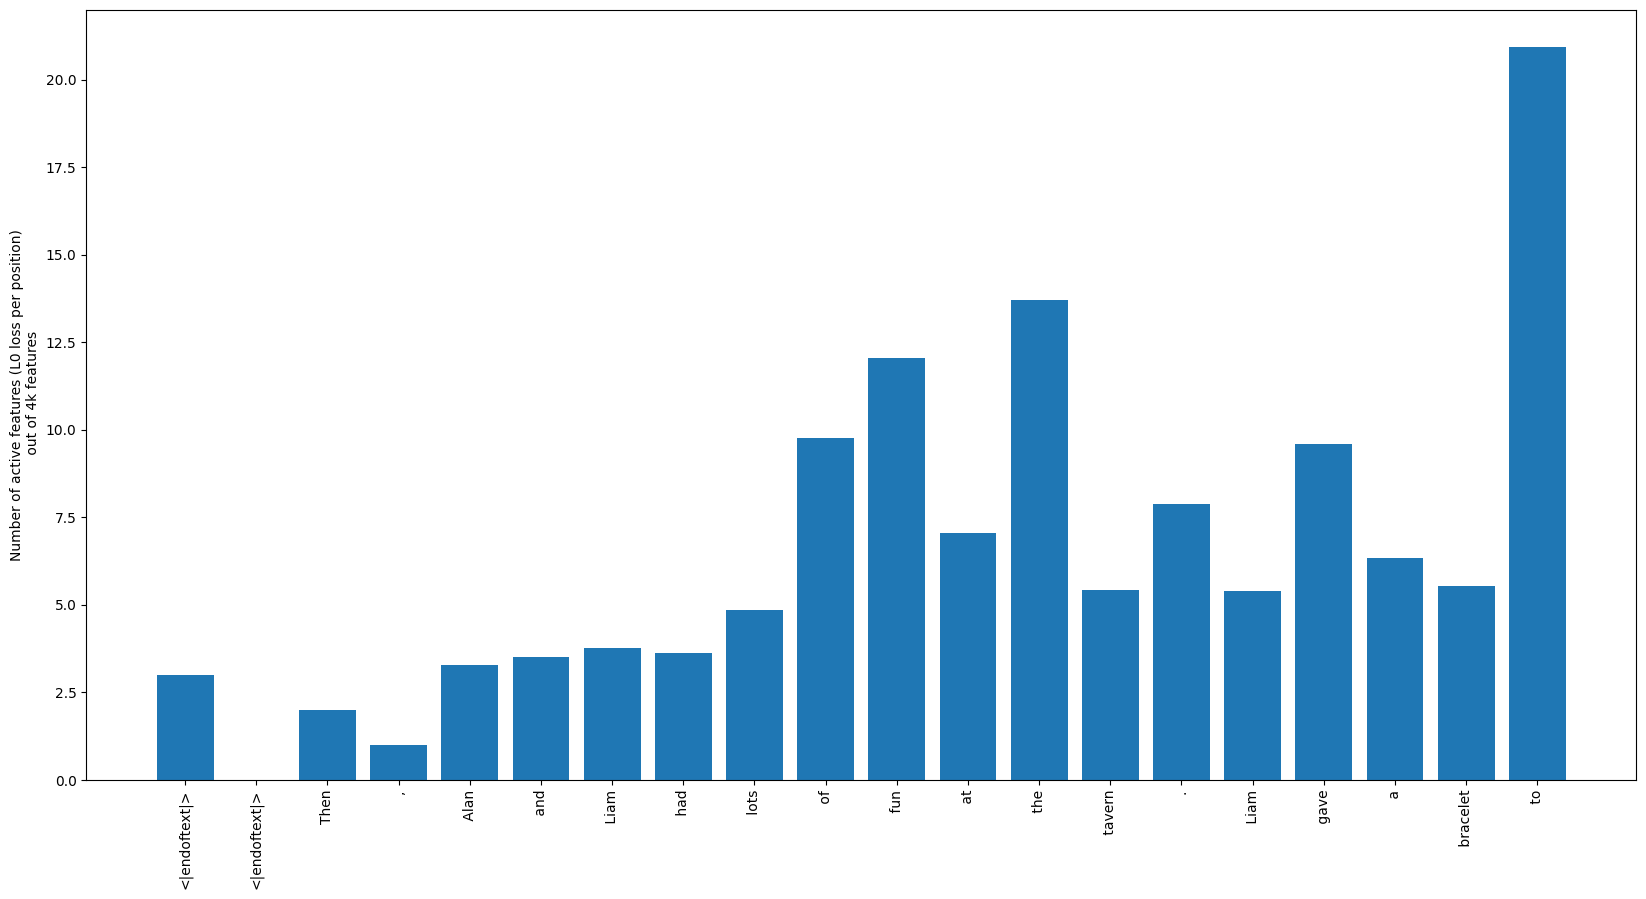

In [48]:
import matplotlib.pyplot as plt

# barplot
plt.figure(figsize=(20, 10))
plt.bar(range(n_features_active.shape[0]), n_features_active.cpu().numpy())
ex_text = model.to_str_tokens(ioi_tokens[0])
plt.xticks(range(n_features_active.shape[0]), [model.tokenizer.bos_token] + ex_text, rotation=90)
plt.ylabel('Number of active features (L0 loss per position)\n out of 4k features')
plt.show()

In [69]:
dead_neurons = torch.zeros(cfg['d_hidden']).cuda()

for batch in ioi_loader:
    # prepend bos
    batch = batch[:10]
    batch = torch.cat([torch.full((batch.shape[0], 1), 50256, device=batch.device, dtype=batch.dtype), batch], dim=1)
    _, cache = model.run_with_cache(batch.cuda(), names_filter=names_filter)
    z = cache[encoder.cfg['actv_name']][:, -1, cfg['head'], :]
    feature_acts = encoder.encoder(z) # [batch, seq, d_hidden]
    dead_neurons += (feature_acts > 1e-7).sum(dim=[0])

    i += 1
    if i > 1000:
        break
ioi_features = torch.topk(dead_neurons, 20)
features = ioi_features.indices
ioi_features.values, features

(tensor([2459., 2415., 2367., 2023., 1951., 1854., 1801., 1711., 1708., 1431.,
         1392., 1384., 1235., 1152., 1102., 1102., 1044.,  989.,  964.,  921.],
        device='cuda:0'),
 tensor([ 555,  383, 2825, 6553, 5608, 5610, 5167, 1541, 6328, 2543,  651, 7865,
         6644, 4385,  596, 6524, 7272, 3248,  811, 6367], device='cuda:0'))

In [42]:
encoder.standard_norm

Parameter containing:
tensor(9, device='cuda:0')

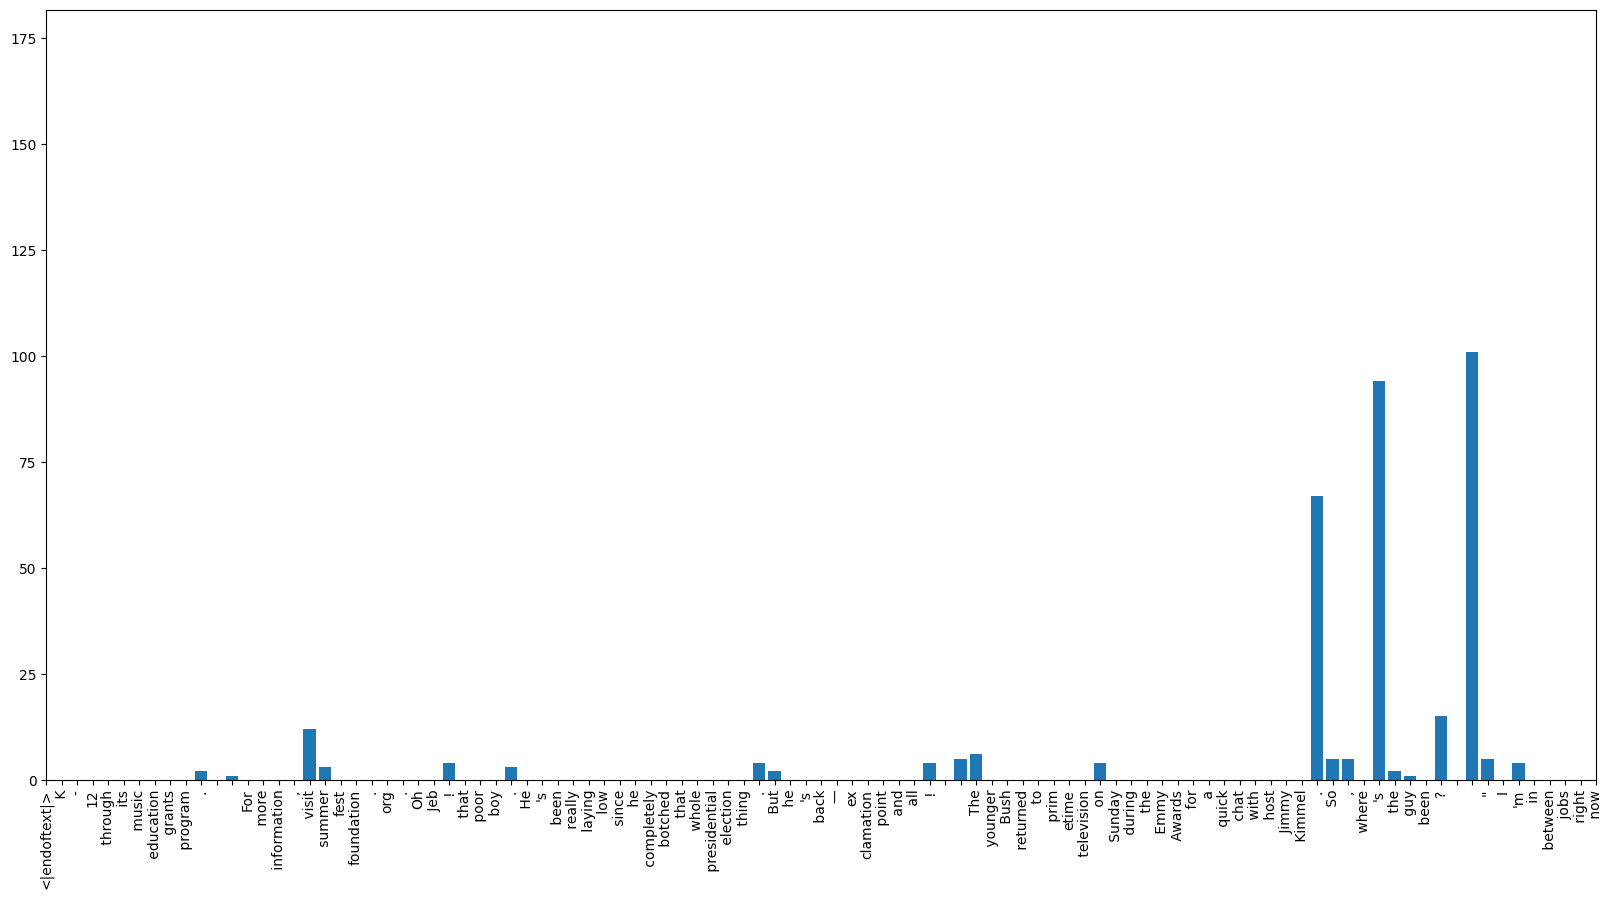

In [52]:
batch = next(iter(text_dataset_loader))#ioi_loader:
# prepend bos
batch = batch[:1]
batch = torch.cat([torch.full((batch.shape[0], 1), 50256, device=batch.device, dtype=batch.dtype), batch], dim=1)
_, cache = model.run_with_cache(batch.cuda())
z = cache[encoder.cfg['actv_name']][:, :, cfg['head'], :]
feature_acts = encoder.encoder(z) # [batch, seq,

plt.figure(figsize=(20, 10))
plt.bar(range(encoder.cfg['seq_len'] + 1), (feature_acts > 1e-7).sum(dim=[0, 2]).cpu().numpy())
ex_text = model.to_str_tokens(batch[0])
plt.xticks(range(encoder.cfg['seq_len'] + 1), ex_text, rotation=90)
plt.xlim(0, 100)
plt.show()

In [19]:
(feature_acts > 1e-7).sum(dim=[0, 2])

torch.Size([129])

In [64]:
new_state_dict = {
    'W_enc': encoder.state_dict()['encoder_map.weight'],
    'b_enc': encoder.state_dict()['encoder_map.bias'],
    'W_dec': encoder.state_dict()['decoder_map.weight'],
    'b_dec': encoder.state_dict()['tied_bias'],
}
new_state_dict

{'W_enc': tensor([[ 0.0573, -0.2218,  0.0162,  ...,  0.2301,  0.2309,  0.0581],
         [ 0.1115, -0.0929, -0.0451,  ...,  0.0452, -0.1430, -0.0537],
         [-0.0038, -0.0015, -0.0018,  ..., -0.0005,  0.0003, -0.0003],
         ...,
         [-0.0408, -0.1059, -0.0744,  ...,  0.0898, -0.0918, -0.0255],
         [-0.0003,  0.0367,  0.0508,  ..., -0.1006, -0.0693, -0.0803],
         [-0.1066,  0.0024, -0.0403,  ..., -0.0681, -0.0713,  0.0407]]),
 'b_enc': tensor([-3.1968, -3.0671, -0.0919,  ..., -1.8058, -3.0700, -1.2074]),
 'W_dec': tensor([[ 0.1483,  0.1209,  0.2336,  ..., -0.0657,  0.0452, -0.1908],
         [-0.1656,  0.0571,  0.0890,  ..., -0.0793,  0.0640, -0.0303],
         [-0.0010, -0.1732,  0.0830,  ..., -0.1400, -0.0087, -0.0632],
         ...,
         [ 0.1635,  0.0835,  0.0703,  ...,  0.1997, -0.1610, -0.1004],
         [ 0.1941, -0.1332,  0.0469,  ..., -0.2192, -0.0414, -0.1608],
         [ 0.1131, -0.0185, -0.0550,  ..., -0.0378,  0.0233,  0.1067]]),
 'b_dec': tensor([

In [10]:
import joblib

codes = joblib.load('data/georg_codes_dict_webtext.joblib')
names = joblib.load('data/names.joblib')
codes, names

({('k',
   2,
   2): {('bias',): tensor([[-1.9192, -0.4495, -4.2893, -0.3413,  1.1199, -2.1033,  1.9600, -0.9251,
            -0.8907, -2.8055, -2.5968,  0.7385, -0.6868,  0.9092, -0.3208, -1.0089,
            -0.0495, -0.3057,  3.3042,  0.0475, -1.1704,  3.0968, -2.1401,  0.8257,
             4.0871,  0.0370, -1.2092,  1.5328, -0.6018,  1.1651, -1.4048,  3.4798,
            -3.0145, -2.9820,  0.8848,  1.2519,  2.2021, -0.5000,  1.4572,  3.0700,
             3.7598,  0.1575,  3.2314,  2.0112, -2.9703,  0.9481, -2.1358, -0.6949,
             3.9107,  2.4794, -1.8617,  2.9900, -2.2810, -3.9459, -3.1299, -2.4277,
            -2.8775,  2.5227,  1.8460,  0.9887,  2.0929, -3.2110,  2.1519,  0.5720]],
          device='cuda:0'), ('s',): tensor([[ 0.5115, -0.1286, -0.0304,  ...,  0.2733, -0.2590,  0.4081],
           [-0.3041,  0.1875, -0.3439,  ..., -0.6077, -0.5571, -0.3204],
           [-0.1090,  0.3403, -0.3059,  ...,  0.2806,  0.9590, -0.4363],
           ...,
           [ 0.0368,  0.2211

In [16]:
#q_l9h9 = codes[78]
#z_l9h9 = codes[79]

In [11]:
z_l9h9 = codes[('z', 9, 9)]
q_l9h9 = codes[('q', 9, 9)]

In [12]:
def cosine_sim(dict_v, name_v):
    ab = einops.einsum(dict_v, name_v, 'd_hidden d_head, n_names d_head -> d_hidden n_names')
    # dict_v all have unit norm
    name_norm = name_v.norm(dim=-1)
    return ab / name_norm

In [13]:
cosine_sim(encoder.W_dec, q_l9h9[('io',)]).min(), cosine_sim(encoder.W_dec, q_l9h9[('io',)]).max()

(tensor(-0.7826, device='cuda:0'), tensor(0.8010, device='cuda:0'))

In [ ]:
cosine_sim(encoder.W_dec, q_l9h9[('io',)]).min(), cosine_sim(encoder.W_dec, q_l9h9[('io',)]).max()


In [14]:
cosine_sim(encoder.W_dec, q_l9h9[('s',)]).min(), cosine_sim(encoder.W_dec, q_l9h9[('s',)]).max()

(tensor(-0.6780, device='cuda:0'), tensor(0.6814, device='cuda:0'))

In [102]:
cosine_sim(encoder.W_dec[2825].view(1, -1), q_l9h9[('io_pos',)][1].view(1, -1))

tensor([[-0.0844]], device='cuda:0')

In [114]:
torch.topk(cosine_sim(encoder.W_dec[2825].view(1, -1), q_l9h9[('io',)]), 10)


torch.return_types.topk(
values=tensor([[0.4213, 0.4076, 0.3973, 0.3883, 0.3854, 0.3757, 0.3461, 0.3407, 0.3231,
         0.3114]], device='cuda:0'),
indices=tensor([[ 54,   8, 167,  66,  77,  80, 188, 108, 204, 106]], device='cuda:0'))

In [124]:
names[106]

'Christian'

In [86]:
encoder.W_dec[16].shape

torch.Size([64])

In [41]:
biggest = torch.topk(cosine_sim(encoder.W_dec, z_l9h9[('io_pos',)][1].view(1, -1)).flatten(), 20)
features = biggest.indices
biggest.values
features

tensor([3839, 3948,  738, 7918, 5204, 4430, 6589, 5465, 5956, 7956, 4876, 4027,
        2862, 5097, 3070, 1837, 1673, 4050, 6193, 6066], device='cuda:0')

In [119]:
rows, cols = cosine_sim(encoder.W_dec, z_l9h9[('io',)]).shape
row_index = biggest // cols
col_index = biggest % cols
row_index, col_index

(tensor(5763, device='cuda:0'), tensor(60, device='cuda:0'))

In [121]:
names[col_index]

'James'

Text(0.5, 1.0, 'Cosine similarity between every ground truth IO name feature \nand the closest feature in the dictionary')

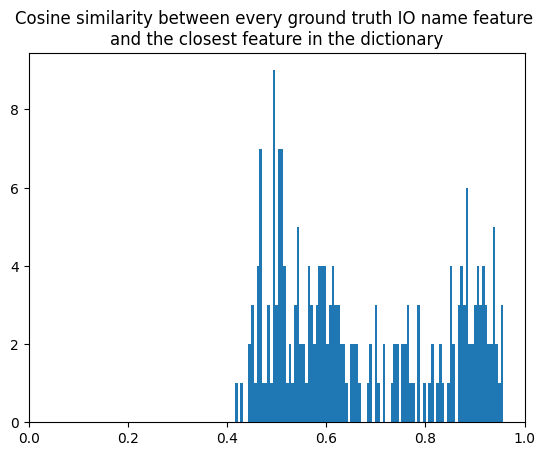

In [87]:
plt.hist(torch.max(cosine_sim(encoder.W_dec, z_l9h9[('io',)]), dim=0).values.cpu(), bins=100)
plt.xlim(0, 1)
plt.title('Cosine similarity between every ground truth IO name feature \nand the closest feature in the dictionary')

In [34]:
a_rand = torch.randn_like(encoder.W_dec)
a_rand = a_rand / a_rand.norm(dim=-1, keepdim=True)
cosine_sim(a_rand, torch.randn_like(q_l9h9['codes'][('s',)])).min()

tensor(-0.5555, device='cuda:0')

In [81]:
sims = cosine_sim(encoder.W_dec, z_l9h9[('s',)][5].view(1, -1))
sims.shape

torch.Size([4096, 1])

In [82]:
sims.argmax(), sims.argmin()

(tensor(694, device='cuda:0'), tensor(1207, device='cuda:0'))

In [89]:
sims.max()

tensor(0.4240, device='cuda:0')

In [84]:
features = [694, 1207]

In [83]:
sims[:10]

tensor([[ 0.1707],
        [-0.0593],
        [-0.1351],
        [-0.0223],
        [ 0.0226],
        [ 0.0952],
        [ 0.2323],
        [-0.1879],
        [ 0.0817],
        [ 0.2068]], device='cuda:0')

In [43]:
'Jen' in codes[0]['names']

True

In [79]:
# which position is Jen?
names.index('William')

5

In [28]:
encoder.cfg

{'lr': 0.001,
 'head': 9,
 'layer': 9,
 'seq_len': 512,
 'd_hidden': 4096,
 'actv_name': 'blocks.9.attn.hook_z',
 'actv_size': 64,
 'ckpt_name': 'z-l9h9-40M-l1_7e-3.ckpt',
 'batch_size': 2048,
 'wandb_name': 'z-l9h9_l1_7e-3_40M_geom_median',
 'buffer_size': 1000000.0,
 'train_steps': 20000,
 'dataset_name': 'Skylion007/openwebtext',
 'l1_coefficient': 0.007,
 'lr_warmup_steps': 3000,
 'resampling_steps': [50000, 100000, 150000, 200000],
 'n_resampler_samples': 819200,
 'extraction_batch_size': 20,
 'init_geometric_median': True,
 'standardize_activations': False,
 'n_resampling_watch_steps': 5000,
 'reconstruction_loss_batch_size': 16,
 'concat_heads': False}